**Deep Learning for Natural Language Processing: Homework 3**

> Eirini Kolimatsi \
> MSc Computer Science, University of Athens \
>
> **Email**: eirini [dot] kolimatsi [at] di [dot] uoa [dot] gr \
> **Student ID**: 7115112200015

## Libraries & Connection
<a name="libraries"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Colab Notebooks/data/imdb-reviews.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from itertools import product
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

!pip install contractions
import contractions
!pip install pyspellchecker
from spellchecker import SpellChecker

# NLTK imports
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer

# pytorch imports
import torchtext
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on: ", device)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

Running on:  cuda


## Data Loading & Preparation

### Functions for data preparation
<a name="dataprep"></a>

In [ ]:
glove300 = torchtext.vocab.GloVe(name="6B", dim=300)

glove_vocab = torchtext.vocab.vocab(glove300.stoi)
glove_vocab.insert_token("<unk>",0)
glove_vocab.insert_token("<pad>",1)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
glove_vocab.set_default_index(0)

pretrained_embeddings = glove300.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:29<00:00, 13497.24it/s]


In [ ]:
# Helpers

# Contractions distionary
contractions_dict = {k.lower(): v for k, v in contractions.contractions_dict.items()}

# Spellchecking: if the typo can't be fixed then do nothing (by default it would return None)
skip_unresolved = lambda fix, typo: fix if fix else typo

def clean_text(text,remove_contractions=True,remove_html_tags=True,remove_punctuation=True,remove_stopwords=True,reduce_length=True,spellchecking=True):

  # lower case
  text = text.lower()

  # remove contractions
  if remove_contractions:
    for key in contractions_dict:
              text = text.replace('\b'+key+'\b', contractions_dict[key])

  # Remove html tags
  if remove_html_tags:
    text = re.sub('<[^>]*>', '', text)

  # Remove punctuation
  if remove_punctuation:
    punc = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text) + ' '.join(punc).replace('-', '')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
  
  # Reduce length in cases of multiple letters eg mistaaaaakesssss
  if reduce_length:
    pattern = re.compile(r"(.)\1{2,}")
    text = ' '.join([pattern.sub(r"\1\1", word) for word in text.split()])

  # Remove stopwords
  if remove_stopwords:
    stop = stopwords.words('english')
    stop.extend(['movie','film','one','like','would'])
    text = ' '.join([word for word in text.split() if word not in (stop)])
  
  # Remove multiple spaces
  text = re.sub(r' +',' ',text).strip()

  # Spelling fixes
  if spellchecking:
    spelling = SpellChecker()
    # words with typos are selected taking into consideration the embeddings
    # if a word is a typo but exists in glove embeddings then it isn't fixed
    words = text.split()
    typo_words = {tw:spelling.correction(tw) for tw in spelling.unknown(words) if tw not in glove.itos}
    text = ' '.join([skip_unresolved(spelling.correction(word),word) if word in typo_words else word for word in words])

  return text.strip()

# Load and prep dataset
def prep_data(data_path):
  df = pd.read_csv(data_path, sep='\t')
  df['review'] = df['review'].progress_apply(clean_text, spellchecking=False)

  df.drop(['url'], axis=1, inplace=True)

  df.loc[df['rating'] <= 4, 'rating'] = 0
  df.loc[df['rating'] >= 7, 'rating'] = 1
  return df

# get glove tokens for each review
def glove_lstm_300_2(row, embedding=glove_vocab, emb2=glove300, embedding_dim = 300, max_len=None):
  splited_words = row.split(' ')
    
  for i, w in enumerate(splited_words):
      if w in emb2.itos:
          splited_words[i] = embedding[w]
      else:
          splited_words[i]=0
  if max_len:
    if len(splited_words)>max_len:
      splited_words = splited_words[:max_len]
    else:
      splited_words += (max_len-len(splited_words))*[1]
  return splited_words

### Data exploration

In [ ]:
df = prep_data(data_path)

100%|██████████| 45008/45008 [01:00<00:00, 744.20it/s]


In [ ]:
# get glove tokens
df['tokenized_review'] = df['review'].progress_apply(glove_lstm_300_2)

100%|██████████| 45008/45008 [20:50<00:00, 35.98it/s]


In [ ]:
df['tokenized_review'][0]

[805, 3743, 220, 2906, 1717, 5573, 255, 41989, 157, 354]

In [ ]:
print('Mean review length:',np.mean(df['review'].apply(str.split).apply(len)))
print('Median review length:',np.median(df['review'].apply(str.split).apply(len)))
print('Max review length:',np.max(df['review'].apply(str.split).apply(len)))
print('Min review length:',np.min(df['review'].apply(str.split).apply(len)))

Mean review length: 114.38966405972272
Median review length: 84.0
Max review length: 1412
Min review length: 3


In [ ]:
# max length set to 115, given this is the mean size of the review
df['tokenized_review_padded']=df['tokenized_review'].apply(lambda x: x[:115] if len(x)>115 else x+[1]*(115-len(x))) 

In [ ]:
df['rating'].value_counts()

1.0    22508
0.0    22500
Name: rating, dtype: int64

In [ ]:
#this cell is used to skip rerunning data prep every time connecting again.

#df.to_csv('/content/drive/My Drive/Colab Notebooks/data/assignment3_processed.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/assignment3_processed.csv')

from ast import literal_eval
df['tokenized_review'] = df['tokenized_review'].apply(literal_eval)
df['tokenized_review_padded'] = df['tokenized_review_padded'].apply(literal_eval)

In [ ]:
df.head()

,Unnamed: 0,rating,review,tokenized_review,rlen,tokenized_review_padded
0,0,1.0,thought quiet good fun watch liked best outtak...,"[805, 3743, 220, 2906, 1717, 5573, 255, 41989,...",10,"[805, 3743, 220, 2906, 1717, 5573, 255, 41989,..."
1,1,1.0,wagon master unique amongst john ford work mai...,"[11382, 2335, 3007, 6836, 280, 1942, 162, 1675...",192,"[11382, 2335, 3007, 6836, 280, 1942, 162, 1675..."
2,2,1.0,near perfect john ford made magic masterpiece ...,"[356, 2616, 280, 1942, 117, 3797, 15024, 1248,...",202,"[356, 2616, 280, 1942, 117, 3797, 15024, 1248,..."
3,3,0.0,gave 4 stars lot interesting themes many alrea...,"[647, 410, 1570, 531, 4002, 5677, 110, 412, 30...",92,"[647, 410, 1570, 531, 4002, 5677, 110, 412, 30..."
4,4,1.0,really genuine random really hard find movies ...,"[589, 7232, 5758, 589, 606, 597, 2460, 41985, ...",91,"[589, 7232, 5758, 589, 606, 597, 2460, 41985, ..."


### Prepare data for training

In [ ]:
X = df['tokenized_review_padded']
y = df['rating']

# Split dataset to train and test set. 90-10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Split train dataset to train and validation set. 80-10-10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.8, random_state=42, stratify=y_train)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", y_val.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", y_test.shape)
print('---------------')
print('class counts of y_train: \n', y_train.value_counts())
print('class counts of y_val: \n', y_val.value_counts())
print('class counts of y_test: \n', y_test.value_counts())

Shape of x_train:  (35443,)
Shape of y_train:  (35443,)
Shape of x_val:   (5064,)
Shape of y_val:   (5064,)
Shape of x_test:   (4501,)
Shape of y_test:   (4501,)
---------------
class counts of y_train: 
 1.0    17725
0.0    17718
Name: rating, dtype: int64
class counts of y_val: 
 1.0    2532
0.0    2532
Name: rating, dtype: int64
class counts of y_test: 
 1.0    2251
0.0    2250
Name: rating, dtype: int64


In [ ]:
# y to tensor
y_train_final = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_val_final = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())
y_test_final = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [ ]:
X_train_final300 = torch.tensor(X_train.to_list())
X_val_final300 = torch.tensor(X_val.to_list())
X_test_final300 = torch.tensor(X_test.to_list())

train_set300 = TensorDataset(X_train_final300, y_train_final)
validation_set300 = TensorDataset(X_val_final300, y_val_final)
test_set300 = TensorDataset(X_test_final300, y_test_final)

max_seq_len = 300
batch_size=32

train_loader300 = DataLoader(train_set300, batch_size= batch_size,
                                     shuffle= True)
val_loader300 = DataLoader(validation_set300, batch_size= batch_size, 
                                    shuffle= False)
test_loader300 = DataLoader(test_set300, batch_size= len(test_set300), #batch_size, 
                                    shuffle= False)

## Models

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, matrix_embeddings, 
               cell_type = nn.LSTM, num_of_classes=1, num_of_layers=4, p=0.5):
    super(SentimentClassifier, self).__init__()
    
    self.hidden_size = hidden_size
    self.cell_type = cell_type
    self.num_of_layers = num_of_layers

    self.embedding = nn.Embedding.from_pretrained(matrix_embeddings, padding_idx=1)

    self.rnn = cell_type(input_size, 
                         hidden_size, 
                         num_of_layers, 
                         bidirectional=True, 
                         dropout=p, 
                         batch_first=True)
    
    self.fc = nn.Linear(hidden_size*2, num_of_classes)

    self.dropout = nn.Dropout(p=p)

  def forward(self, x):
    #print(x.shape)
    
    out = self.embedding(x)
   
    if self.cell_type == nn.GRU:
      out, _ = self.rnn(out)
    else:
      out, (hidden, cell) = self.rnn(out)#x.to(torch.float32))
    #print(out.shape, hidden.shape, cell.shape)
    out = self.dropout(out)

    out = out[:, -1, :]
    out = self.fc(out)
    #print(out)
    return out

## Model Training

### Functions for training
<a name="trainprep"></a>

In [ ]:
# Accuracy
def acc(pred,label):
    return torch.sum(((pred.squeeze() > 0.0) == label.squeeze()).float()).item()

In [ ]:
# Training
def train(model,optimizer,criterion, train_loader,epoch,num_epochs,clip=None):
    model.train()

    tr_loss, train_acc = 0.0, 0.0

    for reviews, labels in train_loader:
        reviews = reviews.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(reviews)

        loss = criterion(outputs.view(-1,), labels)
        loss.backward()

        if clip:
          nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # Metrics
        accuracy = acc(outputs,labels)
        train_acc += accuracy

        tr_loss += loss.item()

    tr_loss = tr_loss / len(train_loader)

    return(tr_loss, train_acc)

In [ ]:
# Validation
def validate(model,optimizer,criterion,val_loader,epoch,num_epochs):
    
    vl_loss, val_acc = 0.0, 0.0

    with torch.no_grad():

        model.eval()

        for reviews, labels in val_loader:

            reviews = reviews.to(device)
            labels = labels.to(device)

            y_ = model(reviews)

            loss = criterion(y_.view(-1,), labels)

            # Metrics
            accuracy = acc(y_,labels)
            val_acc += accuracy

            vl_loss += loss.item()

    vl_loss = vl_loss/len(val_loader)

    return(vl_loss, val_acc)

In [ ]:
# Test
def test(model,test_loader,show_plot_roc_curve=True,show_plot_cm=True,return_results=False,save_plots=None):
  running_loss = 0.0
  score_accuracy = []
  score_f1 = []
  score_precision = []
  score_recall = []

  with torch.no_grad():

    for reviews, labels in test_loader:

        reviews = reviews.to(device)
        labels = labels.to(device)

        y_ = model(reviews)
        y_ = (y_.view(-1,).squeeze()>0.0).float()
        
        # Metrics     
        score_f1.append(f1_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_accuracy.append(accuracy_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_recall.append(recall_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_precision.append(precision_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))

  print("F1:        {:.6f}".format(np.mean(score_f1)*100))
  print("Recall:    {:.6f}".format(np.mean(score_recall)*100))
  print("Precision: {:.6f}".format(np.mean(score_precision)*100))
  print("Accuracy:  {:.6f}".format(np.mean(score_accuracy)*100))

  if show_plot_roc_curve:
    plot_roc(labels.cpu().numpy(),y_.cpu().detach().numpy(),save_plots)
  if show_plot_cm:
    plot_confusion(labels.cpu().numpy(),y_.cpu().detach().numpy(),save_plots)
  if return_results:
    return np.mean(score_f1)*100,np.mean(score_recall)*100,np.mean(score_precision)*100,np.mean(score_accuracy)*100

In [ ]:
# Plot learning curves
def plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs, save_plots):
  X_values = np.arange(num_epochs)

  # Loss vs Epochs
  fig = plt.figure(figsize=(11,5))
  ax1 = fig.add_subplot(121)
  ax1.plot(X_values, train_loss, label= 'train')
  ax1.plot(X_values, val_loss, label= 'validation')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  plt.title('Training & Validation Loss')
  ax1.legend()

  # Accuracy vs Epochs
  ax2 = fig.add_subplot(122)
  ax2.plot(X_values, epoch_tr_acc, label= 'train')
  ax2.plot(X_values, epoch_vl_acc, label= 'validation')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  ax2.legend()

  if save_plots:
    plt.savefig(save_plots+'_loss_acc.png')

  plt.show()

In [ ]:
# Plot confusion matrix
def plot_confusion(y_pred, y_true, save_plots):
  cm = confusion_matrix(y_pred, y_true,labels=[0,1])
  disp = ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive']).plot()

  if save_plots:
    plt.savefig(save_plots+'_cm.png')

  plt.show()

In [ ]:
# Plot ROC curve
def plot_roc(y_pred, y_true, save_plots):
  fpr, tpr, threshold = roc_curve(y_pred, y_true)
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  if save_plots:
    plt.savefig(save_plots+'_roc.png')
  
  plt.show()

In [ ]:
# Run training
def run_epochs(model, num_epochs=5, learning_rate=1e-4, weight_decay=1e-5,
               train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
               show_plot_roc_curve=True, show_plot_cm=True, show_plot_learning=True, 
               show_epoch_results=True, return_results=False, save_model=None, save_plots=None,
               clip=None):

  criterion = nn.BCEWithLogitsLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=weight_decay)

  epoch_tr_loss, epoch_vl_loss = [],[]
  epoch_tr_acc, epoch_vl_acc = [],[]

  train_loss = []
  val_loss = []

  for epoch in range(num_epochs):
    # train
    tr_loss, train_acc = train(model=model,optimizer=optimizer,criterion=criterion, train_loader=train_loader, epoch=epoch, num_epochs=num_epochs)
    train_loss.append(tr_loss)

    # validate
    vl_loss, val_acc = validate(model,optimizer,criterion, val_loader=val_loader, epoch=epoch, num_epochs=num_epochs)
    val_loss.append(vl_loss)
    
    # metrics
    epoch_train_loss = tr_loss
    epoch_val_loss = vl_loss
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(val_loader.dataset)
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    if show_epoch_results:
      print(f'Epoch {epoch+1} | Train Loss: {round(epoch_train_loss,3)} | Val Loss: {round(epoch_val_loss,3)} | Train Acc: {round(epoch_train_acc*100,3)} | Val Acc: {round(epoch_val_acc*100,3)}') 

  if save_model:
    # model_scripted = torch.jit.script(model)
    # model_scripted.save(save_model + '.pt')
    torch.save(model, save_model + '.pt')

  
  if show_plot_learning:
    print('-------------------------')

    plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs, save_plots)

  print('-------------------------')

  # test
  if return_results:

    f1, rc, pr, ac = test(model,test_loader,show_plot_roc_curve=show_plot_roc_curve,show_plot_cm=show_plot_cm,return_results=return_results,save_plots=save_plots)

    return [np.mean(epoch_tr_loss), np.mean(epoch_tr_acc), np.mean(epoch_vl_loss), np.mean(epoch_vl_acc), f1, rc, pr, ac]
  else:
    test(model,test_loader,show_plot_roc_curve=show_plot_roc_curve,show_plot_cm=show_plot_cm,save_plots=save_plots)


### Training - 300d GloVe Embeddings

To train a bidirectional stacked RNN for the task, the training will be based on the following elements:
- the number of hidden layers (60/80/100/120), 
- the number of stacked RNNs (2/3/4/6),
- type of cells (LSTM/GRU cells),
- skip connections, 
- gradient clipping and 
- dropout probability

Obviously, I've experimented more that what can be seen below (eg with learning rates), so practically I'm using certain techniques/choices without showing all the experiments I've done (mostly because they're too many).

### LSTM - Hidden Size

---

Epoch 1 | Train Loss: 0.692 | Val Loss: 0.697 | Train Acc: 51.288 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.691 | Train Acc: 51.491 | Val Acc: 52.251
Epoch 3 | Train Loss: 0.686 | Val Loss: 0.694 | Train Acc: 53.771 | Val Acc: 50.869
Epoch 4 | Train Loss: 0.687 | Val Loss: 0.693 | Train Acc: 53.827 | Val Acc: 50.573
Epoch 5 | Train Loss: 0.653 | Val Loss: 0.524 | Train Acc: 60.167 | Val Acc: 75.355
Epoch 6 | Train Loss: 0.438 | Val Loss: 0.408 | Train Acc: 80.501 | Val Acc: 81.714
Epoch 7 | Train Loss: 0.337 | Val Loss: 0.347 | Train Acc: 85.983 | Val Acc: 85.091
Epoch 8 | Train Loss: 0.286 | Val Loss: 0.333 | Train Acc: 88.5 | Val Acc: 86.078
Epoch 9 | Train Loss: 0.237 | Val Loss: 0.363 | Train Acc: 90.74 | Val Acc: 85.802
Epoch 10 | Train Loss: 0.198 | Val Loss: 0.394 | Train Acc: 92.43 | Val Acc: 85.506
-------------------------


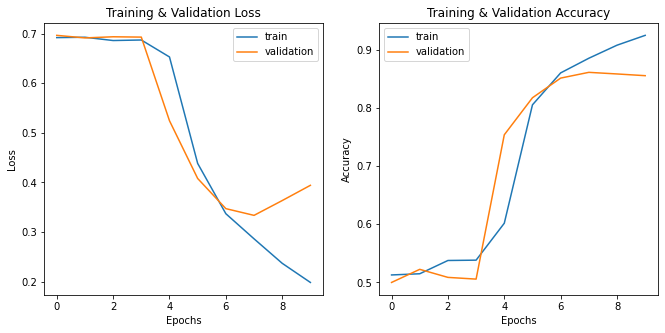

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        86.015589
Recall:    83.340737
Precision: 88.867835
Accuracy:  86.447456
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.484 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.614 | Val Acc: 50.079
Epoch 3 | Train Loss: 0.69 | Val Loss: 0.693 | Train Acc: 52.14 | Val Acc: 50.355
Epoch 4 | Train Loss: 0.683 | Val Loss: 0.693 | Train Acc: 53.892 | Val Acc: 50.987
Epoch 5 | Train Loss: 0.684 | Val Loss: 0.651 | Train Acc: 54.891 | Val Acc: 67.792
Epoch 6 | Train Loss: 0.687 | Val Loss: 0.695 | Train Acc: 52.735 | Val Acc: 51.066
Epoch 7 | Train Loss: 0.684 | Val Loss: 0.695 | Train Acc: 53.731 | Val Acc: 52.034
Epoch 8 | Train Loss: 0.599 | Val Loss: 0.515 | Train Acc: 67.173 | Val Acc: 74.546
Epoch 9 | Train Loss: 0.435 | Val Loss: 0.402 | Train Acc: 80.374 | Val Acc: 81.912
Epoch 10 | Train Loss: 0.349 | Val Loss: 0.368 | Train Acc: 84.956 | Val Acc: 83.59
-------------

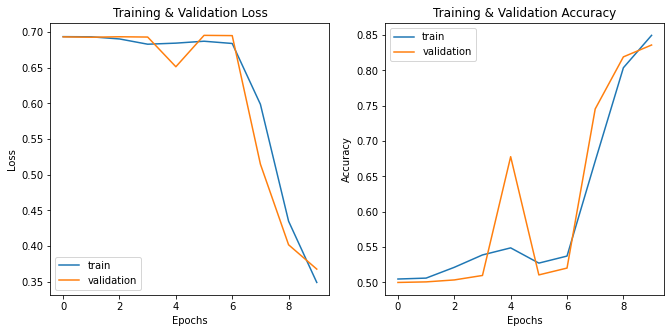

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.588605
Recall:    90.759662
Precision: 80.975030
Accuracy:  84.714508
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.93 | Val Acc: 50.81
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.692 | Train Acc: 51.878 | Val Acc: 51.817
Epoch 3 | Train Loss: 0.689 | Val Loss: 0.692 | Train Acc: 53.068 | Val Acc: 51.264
Epoch 4 | Train Loss: 0.688 | Val Loss: 0.691 | Train Acc: 52.659 | Val Acc: 51.836
Epoch 5 | Train Loss: 0.674 | Val Loss: 0.694 | Train Acc: 55.915 | Val Acc: 50.79
Epoch 6 | Train Loss: 0.666 | Val Loss: 0.616 | Train Acc: 57.966 | Val Acc: 68.76
Epoch 7 | Train Loss: 0.582 | Val Loss: 0.547 | Train Acc: 70.55 | Val Acc: 71.781
Epoch 8 | Train Loss: 0.669 | Val Loss: 0.651 | Train Acc: 56.426 | Val Acc: 61.236
Epoch 9 | Train Loss: 0.582 | Val Loss: 0.507 | Train Acc: 67.616 | Val Acc: 75.632
Epoch 10 | Train Loss: 0.453 | Val Loss: 0.469 | Train Acc: 79.356 | Val Acc: 77.725
-------------

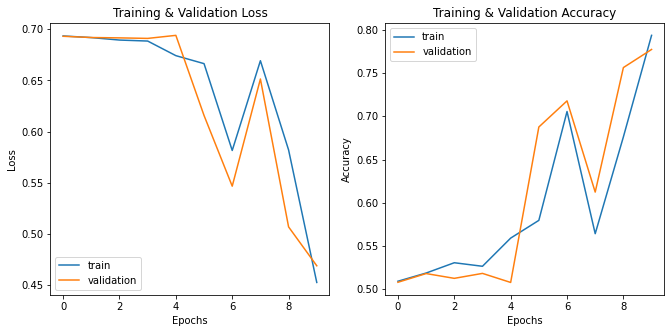

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        75.939135
Recall:    70.946246
Precision: 81.687980
Accuracy:  77.516108
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 49.984 | Val Acc: 50.059
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.689 | Train Acc: 50.901 | Val Acc: 53.476
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 51.229 | Val Acc: 50.81
Epoch 4 | Train Loss: 0.692 | Val Loss: 0.693 | Train Acc: 51.483 | Val Acc: 50.197
Epoch 5 | Train Loss: 0.689 | Val Loss: 0.691 | Train Acc: 52.651 | Val Acc: 52.073
Epoch 6 | Train Loss: 0.687 | Val Loss: 0.693 | Train Acc: 53.98 | Val Acc: 50.474
Epoch 7 | Train Loss: 0.685 | Val Loss: 0.695 | Train Acc: 54.138 | Val Acc: 50.889
Epoch 8 | Train Loss: 0.685 | Val Loss: 0.692 | Train Acc: 53.903 | Val Acc: 51.619
Epoch 9 | Train Loss: 0.623 | Val Loss: 0.485 | Train Acc: 63.733 | Val Acc: 76.639
Epoch 10 | Train Loss: 0.413 | Val Loss: 0.373 | Train Acc: 81.726 | Val Acc: 83.689
----------

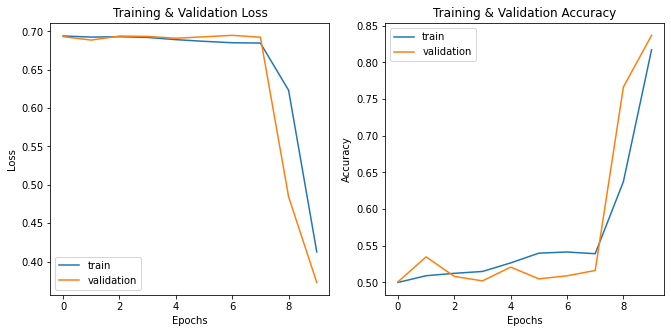

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.661270
Recall:    88.271879
Precision: 81.334425
Accuracy:  84.003555


In [ ]:
for hs in [60,80,100,120]:
  model = SentimentClassifier(300, hs, pretrained_embeddings, num_of_layers=2, 
                              p=0.5, cell_type=nn.LSTM).to(device)

  run_epochs(model, 10, learning_rate=1e-3, clip=2,
            train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
            show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

The results above, show that in general when increasing the hidden size training become less smooth.

### LSTM - Number of stacked RNNs

---



Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.588 | Val Acc: 50.592
Epoch 2 | Train Loss: 0.691 | Val Loss: 0.691 | Train Acc: 52.295 | Val Acc: 50.79
Epoch 3 | Train Loss: 0.692 | Val Loss: 0.686 | Train Acc: 51.61 | Val Acc: 60.861
Epoch 4 | Train Loss: 0.691 | Val Loss: 0.692 | Train Acc: 52.281 | Val Acc: 50.75
Epoch 5 | Train Loss: 0.685 | Val Loss: 0.679 | Train Acc: 54.084 | Val Acc: 58.136
Epoch 6 | Train Loss: 0.522 | Val Loss: 0.455 | Train Acc: 74.458 | Val Acc: 79.463
Epoch 7 | Train Loss: 0.385 | Val Loss: 0.405 | Train Acc: 83.173 | Val Acc: 82.267
Epoch 8 | Train Loss: 0.305 | Val Loss: 0.39 | Train Acc: 87.278 | Val Acc: 84.281
Epoch 9 | Train Loss: 0.24 | Val Loss: 0.398 | Train Acc: 90.545 | Val Acc: 83.551
Epoch 10 | Train Loss: 0.181 | Val Loss: 0.437 | Train Acc: 93.107 | Val Acc: 83.728
-------------------------


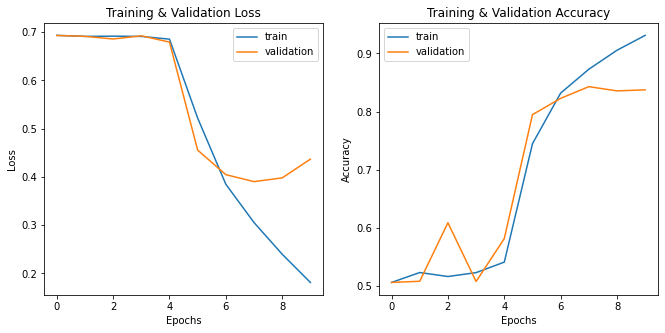

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.424379
Recall:    83.074189
Precision: 85.819183
Accuracy:  84.670073
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.662 | Val Acc: 50.099
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.69 | Train Acc: 51.09 | Val Acc: 53.219
Epoch 3 | Train Loss: 0.69 | Val Loss: 0.684 | Train Acc: 52.617 | Val Acc: 53.851
Epoch 4 | Train Loss: 0.679 | Val Loss: 0.681 | Train Acc: 56.841 | Val Acc: 56.438
Epoch 5 | Train Loss: 0.685 | Val Loss: 0.69 | Train Acc: 53.926 | Val Acc: 52.429
Epoch 6 | Train Loss: 0.684 | Val Loss: 0.691 | Train Acc: 54.383 | Val Acc: 51.698
Epoch 7 | Train Loss: 0.682 | Val Loss: 0.69 | Train Acc: 55.221 | Val Acc: 51.619
Epoch 8 | Train Loss: 0.655 | Val Loss: 0.634 | Train Acc: 61.005 | Val Acc: 65.107
Epoch 9 | Train Loss: 0.523 | Val Loss: 0.443 | Train Acc: 74.432 | Val Acc: 79.759
Epoch 10 | Train Loss: 0.378 | Val Loss: 0.368 | Train Acc: 83.427 | Val Acc: 83.116
-------------

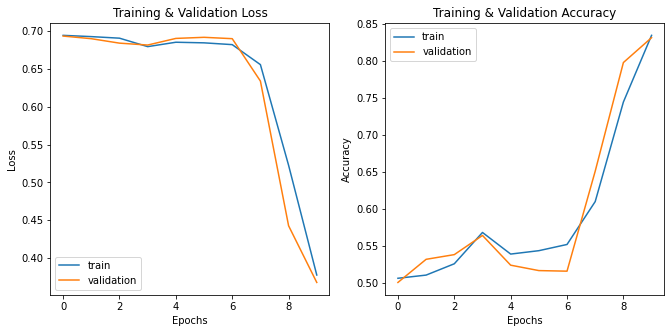

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.810690
Recall:    84.584629
Precision: 85.037963
Accuracy:  84.847812
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.769 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.097 | Val Acc: 50.0
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.399 | Val Acc: 50.0
Epoch 4 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.877 | Val Acc: 50.0
Epoch 5 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.725 | Val Acc: 50.0
Epoch 6 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.917 | Val Acc: 50.0
Epoch 7 | Train Loss: 0.694 | Val Loss: 0.694 | Train Acc: 50.168 | Val Acc: 50.0
Epoch 8 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.292 | Val Acc: 50.296
Epoch 9 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.626 | Val Acc: 50.0
Epoch 10 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 50.315 | Val Acc: 50.0
-------------------------


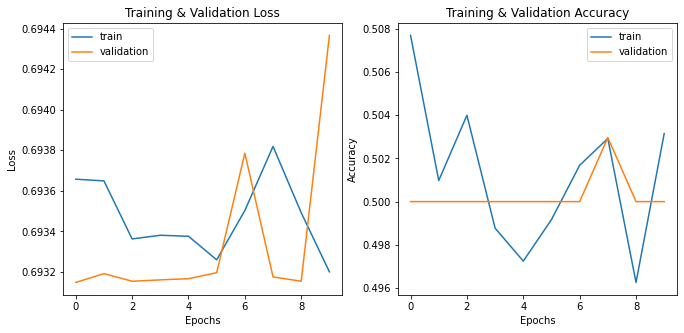

-------------------------
torch.Size([4501, 1])
torch.Size([4501])


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:        0.000000
Recall:    0.000000
Precision: 0.000000
Accuracy:  49.988891
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 49.962 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.987 | Val Acc: 50.0
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.695 | Train Acc: 50.385 | Val Acc: 50.0
Epoch 4 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.841 | Val Acc: 50.0
Epoch 5 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.987 | Val Acc: 50.0
Epoch 6 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.103 | Val Acc: 50.0
Epoch 7 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.968 | Val Acc: 50.0
Epoch 8 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.883 | Val Acc: 50.0
Epoch 9 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.171 | Val Acc: 50.0
Epoch 10 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.114 | Val Acc: 50.0
-------------------------


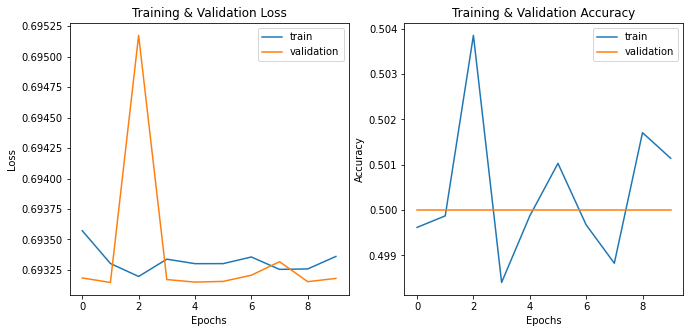

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        66.676540
Recall:    100.000000
Precision: 50.011109
Accuracy:  50.011109


In [ ]:
for l in [2,3,4,6]:
  model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=l, 
                              p=0.5, cell_type=nn.LSTM).to(device)

  run_epochs(model, 10, learning_rate=1e-3, clip=2,
            train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
            show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

Increasing the number of stacked LSTMs doesn't have good results. This should be due to the fact that the training data are not so big and usually having more layers improves the performance when having more data.

### GRU - Hidden Size

---

---------60--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.224 | Val Acc: 50.592
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.566 | Val Acc: 51.402
Epoch 3 | Train Loss: 0.692 | Val Loss: 0.692 | Train Acc: 51.477 | Val Acc: 51.876
Epoch 4 | Train Loss: 0.688 | Val Loss: 0.684 | Train Acc: 52.496 | Val Acc: 55.273
Epoch 5 | Train Loss: 0.679 | Val Loss: 0.711 | Train Acc: 57.467 | Val Acc: 51.915
Epoch 6 | Train Loss: 0.674 | Val Loss: 0.689 | Train Acc: 58.655 | Val Acc: 51.876
Epoch 7 | Train Loss: 0.678 | Val Loss: 0.664 | Train Acc: 56.395 | Val Acc: 60.486
Epoch 8 | Train Loss: 0.694 | Val Loss: 0.69 | Train Acc: 52.14 | Val Acc: 52.073
Epoch 9 | Train Loss: 0.685 | Val Loss: 0.687 | Train Acc: 53.977 | Val Acc: 53.535
Epoch 10 | Train Loss: 0.667 | Val Loss: 0.752 | Train Acc: 59.01 | Val Acc: 50.889
-------------------------


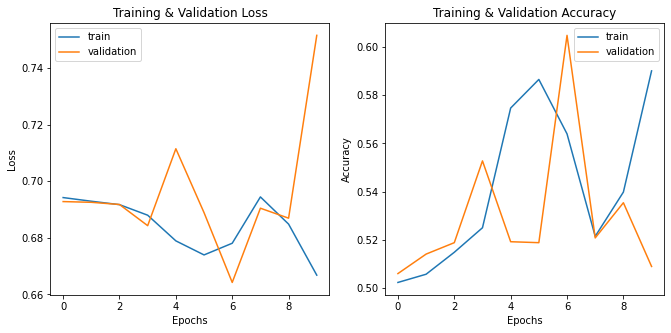

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        66.915832
Recall:    99.422479
Precision: 50.428121
Accuracy:  50.833148
---------80--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.219 | Val Acc: 51.047
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.692 | Train Acc: 51.28 | Val Acc: 51.165
Epoch 3 | Train Loss: 0.689 | Val Loss: 0.692 | Train Acc: 52.922 | Val Acc: 51.521
Epoch 4 | Train Loss: 0.675 | Val Loss: 0.635 | Train Acc: 56.194 | Val Acc: 66.765
Epoch 5 | Train Loss: 0.643 | Val Loss: 0.635 | Train Acc: 65.184 | Val Acc: 67.22
Epoch 6 | Train Loss: 0.672 | Val Loss: 0.676 | Train Acc: 57.693 | Val Acc: 56.082
Epoch 7 | Train Loss: 0.673 | Val Loss: 0.688 | Train Acc: 57.695 | Val Acc: 53.574
Epoch 8 | Train Loss: 0.682 | Val Loss: 0.688 | Train Acc: 54.575 | Val Acc: 52.784
Epoch 9 | Train Loss: 0.683 | Val Loss: 0.685 | Train Acc: 54.239 | Val Acc: 53.811
Epoch 10 | Train Loss: 0.654 | Val Loss: 0.63 | Train Acc: 61.222 | Val Acc

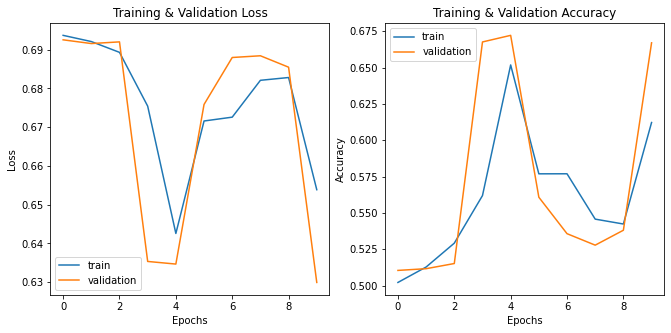

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        63.540670
Recall:    58.996002
Precision: 68.843961
Accuracy:  66.140858
---------100--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.58 | Val Acc: 50.948
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.693 | Train Acc: 51.454 | Val Acc: 51.007
Epoch 3 | Train Loss: 0.689 | Val Loss: 0.691 | Train Acc: 53.054 | Val Acc: 51.323
Epoch 4 | Train Loss: 0.684 | Val Loss: 0.675 | Train Acc: 54.394 | Val Acc: 54.384
Epoch 5 | Train Loss: 0.651 | Val Loss: 0.615 | Train Acc: 61.803 | Val Acc: 68.148
Epoch 6 | Train Loss: 0.596 | Val Loss: 0.589 | Train Acc: 69.317 | Val Acc: 69.194
Epoch 7 | Train Loss: 0.574 | Val Loss: 0.558 | Train Acc: 71.018 | Val Acc: 72.156
Epoch 8 | Train Loss: 0.54 | Val Loss: 0.579 | Train Acc: 73.258 | Val Acc: 70.616
Epoch 9 | Train Loss: 0.5 | Val Loss: 0.496 | Train Acc: 75.933 | Val Acc: 76.126
Epoch 10 | Train Loss: 0.447 | Val Loss: 0.452 | Train Acc: 79.282 | Val Acc

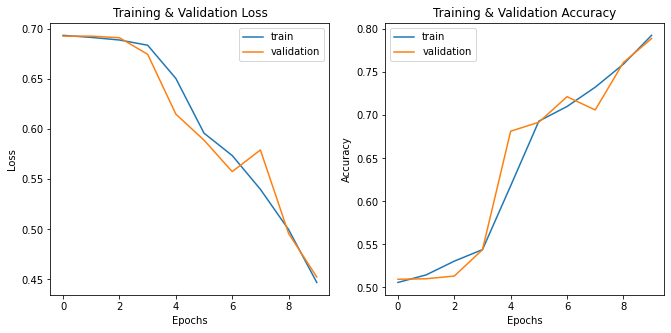

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        80.254516
Recall:    86.850289
Precision: 74.589851
Accuracy:  78.626972
---------120--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.512 | Val Acc: 49.941
Epoch 2 | Train Loss: 0.691 | Val Loss: 0.689 | Train Acc: 52.115 | Val Acc: 52.863
Epoch 3 | Train Loss: 0.679 | Val Loss: 0.671 | Train Acc: 55.845 | Val Acc: 57.741
Epoch 4 | Train Loss: 0.678 | Val Loss: 0.686 | Train Acc: 55.754 | Val Acc: 56.615
Epoch 5 | Train Loss: 0.609 | Val Loss: 0.608 | Train Acc: 66.391 | Val Acc: 69.787
Epoch 6 | Train Loss: 0.538 | Val Loss: 0.51 | Train Acc: 73.651 | Val Acc: 75.573
Epoch 7 | Train Loss: 0.468 | Val Loss: 0.449 | Train Acc: 78.041 | Val Acc: 79.68
Epoch 8 | Train Loss: 0.404 | Val Loss: 0.41 | Train Acc: 81.937 | Val Acc: 82.03
Epoch 9 | Train Loss: 0.363 | Val Loss: 0.393 | Train Acc: 84.186 | Val Acc: 82.662
Epoch 10 | Train Loss: 0.335 | Val Loss: 0.381 | Train Acc: 85.582 | Val Acc

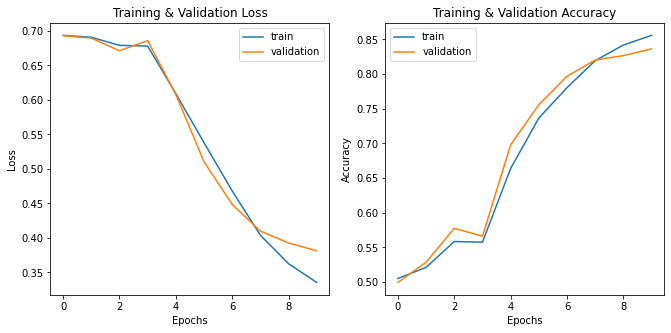

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.326344
Recall:    90.226566
Precision: 79.150429
Accuracy:  83.225950


In [ ]:
for hs in [60,80,100,120]:
  print(f"---------{hs}--------")
  model = SentimentClassifier(300, hs, pretrained_embeddings, num_of_layers=2, 
                              p=0.5, cell_type=nn.GRU).to(device)

  run_epochs(model, 10 , learning_rate=1e-4, clip=2,
            train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
            show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

Given the above results, we can see that the net with the GRU cells seem to perform better when the number of hidden layers is larger, so we're going to train again for 140 and 160 hidden layers.

---------140--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.416 | Val Acc: 50.612
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.687 | Train Acc: 52.23 | Val Acc: 53.969
Epoch 3 | Train Loss: 0.57 | Val Loss: 0.51 | Train Acc: 70.826 | Val Acc: 75.415
Epoch 4 | Train Loss: 0.457 | Val Loss: 0.434 | Train Acc: 79.014 | Val Acc: 80.352
Epoch 5 | Train Loss: 0.384 | Val Loss: 0.424 | Train Acc: 83.142 | Val Acc: 80.115
Epoch 6 | Train Loss: 0.346 | Val Loss: 0.371 | Train Acc: 85.131 | Val Acc: 83.867
Epoch 7 | Train Loss: 0.323 | Val Loss: 0.362 | Train Acc: 86.155 | Val Acc: 84.044
Epoch 8 | Train Loss: 0.303 | Val Loss: 0.355 | Train Acc: 87.368 | Val Acc: 84.676
Epoch 9 | Train Loss: 0.288 | Val Loss: 0.367 | Train Acc: 87.984 | Val Acc: 84.617
Epoch 10 | Train Loss: 0.275 | Val Loss: 0.362 | Train Acc: 88.692 | Val Acc: 84.518
-------------------------


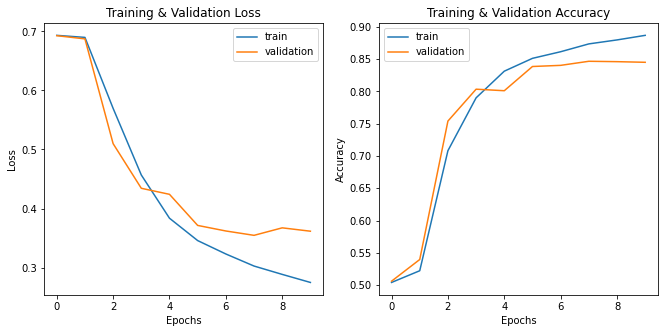

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.707855
Recall:    84.584629
Precision: 86.861314
Accuracy:  85.892024
---------160--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.707 | Val Acc: 50.711
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.69 | Train Acc: 53.13 | Val Acc: 51.58
Epoch 3 | Train Loss: 0.625 | Val Loss: 0.551 | Train Acc: 63.922 | Val Acc: 72.334
Epoch 4 | Train Loss: 0.521 | Val Loss: 0.481 | Train Acc: 74.624 | Val Acc: 77.034
Epoch 5 | Train Loss: 0.44 | Val Loss: 0.416 | Train Acc: 79.638 | Val Acc: 80.45
Epoch 6 | Train Loss: 0.373 | Val Loss: 0.38 | Train Acc: 83.593 | Val Acc: 82.603
Epoch 7 | Train Loss: 0.341 | Val Loss: 0.391 | Train Acc: 85.399 | Val Acc: 83.096
Epoch 8 | Train Loss: 0.317 | Val Loss: 0.375 | Train Acc: 86.598 | Val Acc: 83.728
Epoch 9 | Train Loss: 0.299 | Val Loss: 0.36 | Train Acc: 87.385 | Val Acc: 84.874
Epoch 10 | Train Loss: 0.283 | Val Loss: 0.378 | Train Acc: 88.331 | Val Acc: 8

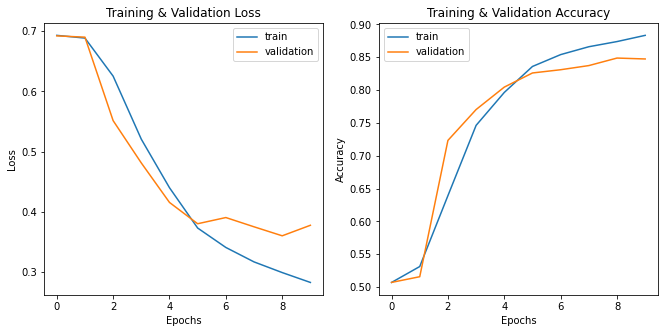

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.574572
Recall:    85.517548
Precision: 85.631673
Accuracy:  85.580982


In [ ]:
for hs in [140,160]:
  print(f"---------{hs}--------")
  model = SentimentClassifier(300, hs, pretrained_embeddings, num_of_layers=2, 
                              p=0.5, cell_type=nn.GRU).to(device)

  run_epochs(model, 10 , learning_rate=1e-4, clip=2,
            train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
            show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

The results seem to keep improving while we're increasing the hidden size, but now there's some overfitting so further tuning regarding the learning rate will be needed if any of these models are selected at the end.

### GRU - Number of stacked RNNs


---



---------2--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.157 | Val Acc: 51.165
Epoch 2 | Train Loss: 0.691 | Val Loss: 0.689 | Train Acc: 52.194 | Val Acc: 52.626
Epoch 3 | Train Loss: 0.656 | Val Loss: 0.625 | Train Acc: 61.456 | Val Acc: 67.753
Epoch 4 | Train Loss: 0.617 | Val Loss: 0.606 | Train Acc: 68.143 | Val Acc: 70.419
Epoch 5 | Train Loss: 0.602 | Val Loss: 0.596 | Train Acc: 69.153 | Val Acc: 68.246
Epoch 6 | Train Loss: 0.562 | Val Loss: 0.552 | Train Acc: 72.15 | Val Acc: 72.551
Epoch 7 | Train Loss: 0.561 | Val Loss: 0.69 | Train Acc: 71.046 | Val Acc: 55.47
Epoch 8 | Train Loss: 0.651 | Val Loss: 0.545 | Train Acc: 59.549 | Val Acc: 73.124
Epoch 9 | Train Loss: 0.512 | Val Loss: 0.507 | Train Acc: 75.496 | Val Acc: 75.948
Epoch 10 | Train Loss: 0.478 | Val Loss: 0.477 | Train Acc: 77.462 | Val Acc: 77.113
-------------------------


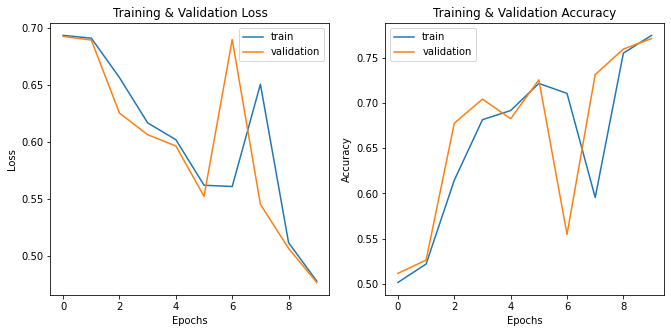

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        77.148568
Recall:    77.165704
Precision: 77.131439
Accuracy:  77.138414
---------3--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.492 | Val Acc: 52.291
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.683 | Train Acc: 52.755 | Val Acc: 54.246
Epoch 3 | Train Loss: 0.673 | Val Loss: 0.606 | Train Acc: 56.564 | Val Acc: 69.451
Epoch 4 | Train Loss: 0.532 | Val Loss: 0.525 | Train Acc: 74.054 | Val Acc: 74.585
Epoch 5 | Train Loss: 0.446 | Val Loss: 0.425 | Train Acc: 79.485 | Val Acc: 80.332
Epoch 6 | Train Loss: 0.381 | Val Loss: 0.393 | Train Acc: 83.15 | Val Acc: 82.642
Epoch 7 | Train Loss: 0.351 | Val Loss: 0.38 | Train Acc: 84.84 | Val Acc: 83.452
Epoch 8 | Train Loss: 0.323 | Val Loss: 0.384 | Train Acc: 86.372 | Val Acc: 84.696
Epoch 9 | Train Loss: 0.306 | Val Loss: 0.381 | Train Acc: 86.996 | Val Acc: 84.261
Epoch 10 | Train Loss: 0.29 | Val Loss: 0.356 | Train Acc: 87.817 | Val Acc: 

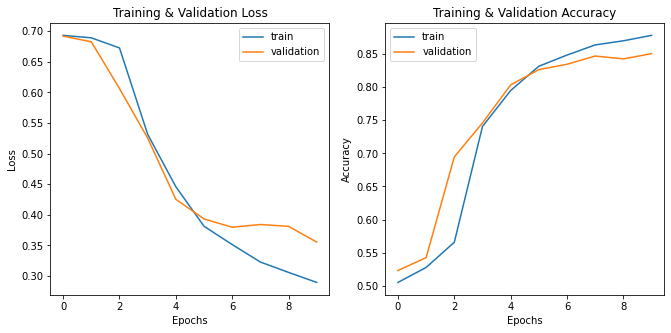

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.073301
Recall:    85.073301
Precision: 85.073301
Accuracy:  85.069984
---------4--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.453 | Val Acc: 50.75
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.683 | Train Acc: 53.009 | Val Acc: 54.088
Epoch 3 | Train Loss: 0.564 | Val Loss: 0.506 | Train Acc: 71.506 | Val Acc: 75.158
Epoch 4 | Train Loss: 0.457 | Val Loss: 0.44 | Train Acc: 78.961 | Val Acc: 79.818
Epoch 5 | Train Loss: 0.389 | Val Loss: 0.407 | Train Acc: 82.569 | Val Acc: 81.24
Epoch 6 | Train Loss: 0.352 | Val Loss: 0.389 | Train Acc: 84.728 | Val Acc: 83.096
Epoch 7 | Train Loss: 0.325 | Val Loss: 0.403 | Train Acc: 86.099 | Val Acc: 83.017
Epoch 8 | Train Loss: 0.31 | Val Loss: 0.386 | Train Acc: 86.866 | Val Acc: 84.163
Epoch 9 | Train Loss: 0.292 | Val Loss: 0.375 | Train Acc: 88.006 | Val Acc: 83.156
Epoch 10 | Train Loss: 0.276 | Val Loss: 0.377 | Train Acc: 88.709 | Val Acc: 

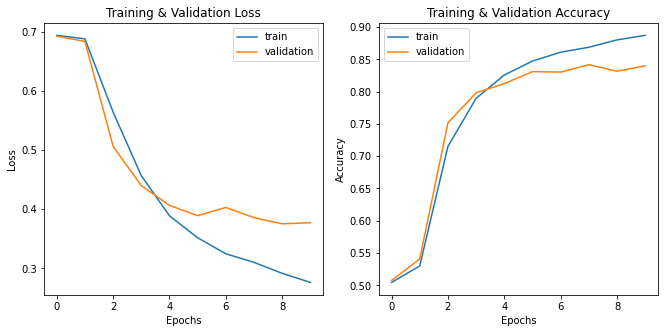

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.438306
Recall:    81.474900
Precision: 87.625418
Accuracy:  84.981115
---------6--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 49.934 | Val Acc: 51.718
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.684 | Train Acc: 52.462 | Val Acc: 54.206
Epoch 3 | Train Loss: 0.61 | Val Loss: 0.533 | Train Acc: 66.227 | Val Acc: 73.874
Epoch 4 | Train Loss: 0.485 | Val Loss: 0.453 | Train Acc: 77.319 | Val Acc: 78.495
Epoch 5 | Train Loss: 0.409 | Val Loss: 0.451 | Train Acc: 81.757 | Val Acc: 80.233
Epoch 6 | Train Loss: 0.362 | Val Loss: 0.383 | Train Acc: 84.163 | Val Acc: 83.136
Epoch 7 | Train Loss: 0.335 | Val Loss: 0.369 | Train Acc: 85.656 | Val Acc: 83.886
Epoch 8 | Train Loss: 0.311 | Val Loss: 0.371 | Train Acc: 86.925 | Val Acc: 83.175
Epoch 9 | Train Loss: 0.3 | Val Loss: 0.393 | Train Acc: 87.718 | Val Acc: 83.57
Epoch 10 | Train Loss: 0.282 | Val Loss: 0.428 | Train Acc: 88.387 | Val Acc: 

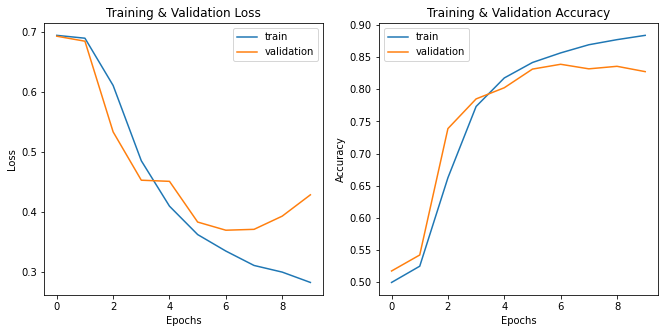

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.613842
Recall:    93.691693
Precision: 77.139722
Accuracy:  82.959342


In [ ]:
for l in [2,3,4,6]:
  print(f"---------{l}--------")
  model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=l, 
                              p=0.5, cell_type=nn.GRU).to(device)

  run_epochs(model, 10 , learning_rate=1e-4, clip=2,
            train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
            show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

As we can see, similarly with the LSTM experiments regarding the number of stacked RNNs, as the number of stacked RNNs increase the results get worse, however the GRU cells seem to respond better than LSTM cells to more layers. We notice from both the LSTM and the GRU experiments that up to 3 layers is the point at which training results are good.

### Gradient Clipping


---


---------(<class 'torch.nn.modules.rnn.GRU'>, -1)--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.484 | Val Acc: 51.54
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.688 | Train Acc: 52.504 | Val Acc: 52.567
Epoch 3 | Train Loss: 0.646 | Val Loss: 0.632 | Train Acc: 60.988 | Val Acc: 65.363
Epoch 4 | Train Loss: 0.528 | Val Loss: 0.502 | Train Acc: 73.837 | Val Acc: 75.671
Epoch 5 | Train Loss: 0.454 | Val Loss: 0.464 | Train Acc: 78.777 | Val Acc: 78.12
Epoch 6 | Train Loss: 0.397 | Val Loss: 0.443 | Train Acc: 82.191 | Val Acc: 79.66
Epoch 7 | Train Loss: 0.357 | Val Loss: 0.406 | Train Acc: 84.372 | Val Acc: 82.208
Epoch 8 | Train Loss: 0.334 | Val Loss: 0.366 | Train Acc: 85.529 | Val Acc: 84.084
Epoch 9 | Train Loss: 0.31 | Val Loss: 0.364 | Train Acc: 86.821 | Val Acc: 84.696
Epoch 10 | Train Loss: 0.296 | Val Loss: 0.384 | Train Acc: 87.69 | Val Acc: 83.096
-------------------------


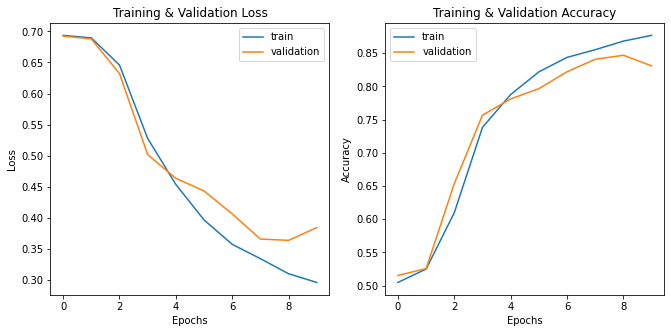

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        82.195704
Recall:    76.499334
Precision: 88.808664
Accuracy:  83.425905
---------(<class 'torch.nn.modules.rnn.GRU'>, 1)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.605 | Val Acc: 51.442
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.687 | Train Acc: 51.959 | Val Acc: 52.686
Epoch 3 | Train Loss: 0.593 | Val Loss: 0.512 | Train Acc: 67.585 | Val Acc: 75.296
Epoch 4 | Train Loss: 0.466 | Val Loss: 0.44 | Train Acc: 78.34 | Val Acc: 79.562
Epoch 5 | Train Loss: 0.388 | Val Loss: 0.414 | Train Acc: 82.871 | Val Acc: 82.089
Epoch 6 | Train Loss: 0.352 | Val Loss: 0.385 | Train Acc: 84.736 | Val Acc: 82.919
Epoch 7 | Train Loss: 0.328 | Val Loss: 0.379 | Train Acc: 86.042 | Val Acc: 83.353
Epoch 8 | Train Loss: 0.307 | Val Loss: 0.451 | Train Acc: 87.033 | Val Acc: 81.675
Epoch 9 | Train Loss: 0.289 | Val Loss: 0.406 | Train Acc: 87.95 | Val Acc: 84.301
Epoch 10 | Train Loss: 0.273 | Val Loss:

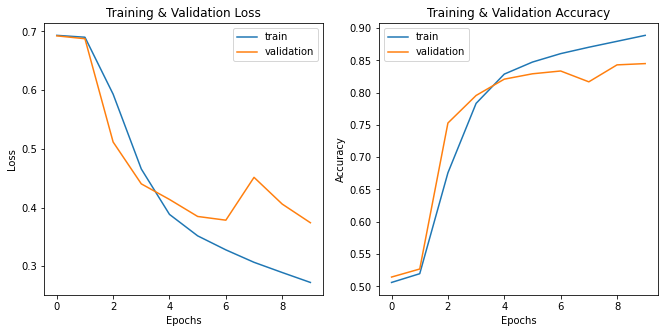

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.320706
Recall:    88.049756
Precision: 82.755741
Accuracy:  84.847812
---------(<class 'torch.nn.modules.rnn.GRU'>, 2)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.478 | Val Acc: 50.849
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.686 | Train Acc: 52.202 | Val Acc: 53.199
Epoch 3 | Train Loss: 0.68 | Val Loss: 0.67 | Train Acc: 55.249 | Val Acc: 57.188
Epoch 4 | Train Loss: 0.557 | Val Loss: 0.496 | Train Acc: 71.467 | Val Acc: 75.77
Epoch 5 | Train Loss: 0.458 | Val Loss: 0.434 | Train Acc: 78.566 | Val Acc: 79.759
Epoch 6 | Train Loss: 0.393 | Val Loss: 0.405 | Train Acc: 82.287 | Val Acc: 82.129
Epoch 7 | Train Loss: 0.357 | Val Loss: 0.387 | Train Acc: 84.169 | Val Acc: 82.761
Epoch 8 | Train Loss: 0.328 | Val Loss: 0.409 | Train Acc: 85.743 | Val Acc: 82.504
Epoch 9 | Train Loss: 0.309 | Val Loss: 0.38 | Train Acc: 86.731 | Val Acc: 83.551
Epoch 10 | Train Loss: 0.291 | Val Loss: 

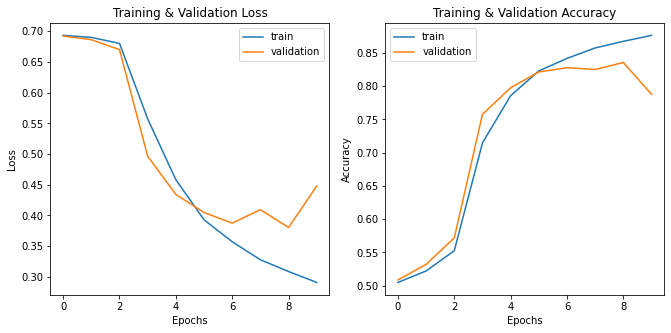

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        75.406397
Recall:    63.882719
Precision: 92.002559
Accuracy:  79.160187
---------(<class 'torch.nn.modules.rnn.GRU'>, 5)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.416 | Val Acc: 51.679
Epoch 2 | Train Loss: 0.687 | Val Loss: 0.638 | Train Acc: 53.139 | Val Acc: 65.284
Epoch 3 | Train Loss: 0.551 | Val Loss: 0.503 | Train Acc: 72.708 | Val Acc: 75.731
Epoch 4 | Train Loss: 0.451 | Val Loss: 0.436 | Train Acc: 79.31 | Val Acc: 79.265
Epoch 5 | Train Loss: 0.39 | Val Loss: 0.433 | Train Acc: 82.789 | Val Acc: 79.838
Epoch 6 | Train Loss: 0.352 | Val Loss: 0.378 | Train Acc: 84.804 | Val Acc: 83.116
Epoch 7 | Train Loss: 0.327 | Val Loss: 0.404 | Train Acc: 86.045 | Val Acc: 83.728
Epoch 8 | Train Loss: 0.307 | Val Loss: 0.385 | Train Acc: 87.021 | Val Acc: 84.044
Epoch 9 | Train Loss: 0.291 | Val Loss: 0.359 | Train Acc: 87.91 | Val Acc: 84.577
Epoch 10 | Train Loss: 0.278 | Val Loss

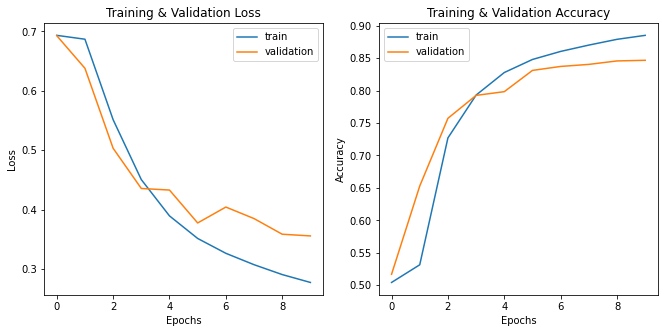

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.888305
Recall:    86.095069
Precision: 83.714903
Accuracy:  84.670073
---------(<class 'torch.nn.modules.rnn.GRU'>, None)--------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.295 | Val Acc: 50.513
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.687 | Train Acc: 51.796 | Val Acc: 53.436
Epoch 3 | Train Loss: 0.565 | Val Loss: 0.558 | Train Acc: 71.255 | Val Acc: 72.611
Epoch 4 | Train Loss: 0.452 | Val Loss: 0.43 | Train Acc: 79.04 | Val Acc: 79.799
Epoch 5 | Train Loss: 0.386 | Val Loss: 0.412 | Train Acc: 82.84 | Val Acc: 81.517
Epoch 6 | Train Loss: 0.348 | Val Loss: 0.378 | Train Acc: 84.903 | Val Acc: 83.057
Epoch 7 | Train Loss: 0.324 | Val Loss: 0.396 | Train Acc: 86.116 | Val Acc: 83.057
Epoch 8 | Train Loss: 0.306 | Val Loss: 0.363 | Train Acc: 87.205 | Val Acc: 85.032
Epoch 9 | Train Loss: 0.289 | Val Loss: 0.36 | Train Acc: 87.921 | Val Acc: 84.321
Epoch 10 | Train Loss: 0.275 | Val Los

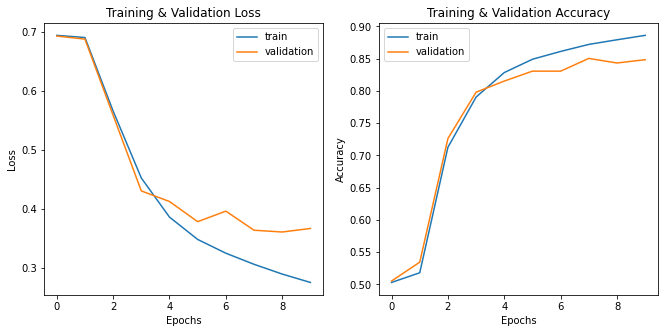

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.387438
Recall:    87.872057
Precision: 83.039463
Accuracy:  84.958898
---------(<class 'torch.nn.modules.rnn.LSTM'>, -1)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.286 | Val Acc: 51.422
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.688 | Train Acc: 52.061 | Val Acc: 54.897
Epoch 3 | Train Loss: 0.648 | Val Loss: 0.633 | Train Acc: 63.282 | Val Acc: 65.087
Epoch 4 | Train Loss: 0.6 | Val Loss: 0.59 | Train Acc: 68.761 | Val Acc: 69.234
Epoch 5 | Train Loss: 0.555 | Val Loss: 0.554 | Train Acc: 72.203 | Val Acc: 72.532
Epoch 6 | Train Loss: 0.505 | Val Loss: 0.493 | Train Acc: 75.702 | Val Acc: 76.619
Epoch 7 | Train Loss: 0.441 | Val Loss: 0.447 | Train Acc: 79.796 | Val Acc: 79.443
Epoch 8 | Train Loss: 0.383 | Val Loss: 0.401 | Train Acc: 83.212 | Val Acc: 82.899
Epoch 9 | Train Loss: 0.347 | Val Loss: 0.39 | Train Acc: 85.187 | Val Acc: 82.78
Epoch 10 | Train Loss: 0.321 | Val Loss

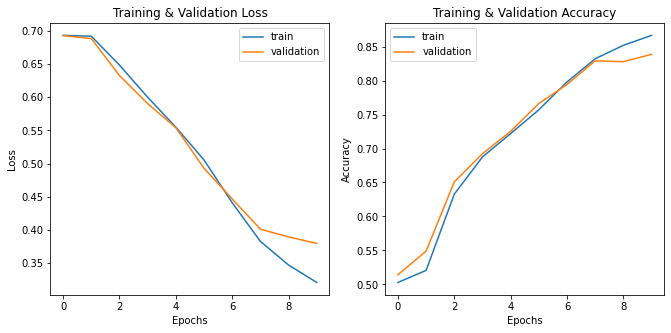

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.133006
Recall:    83.740560
Precision: 84.529148
Accuracy:  84.203510
---------(<class 'torch.nn.modules.rnn.LSTM'>, 1)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.605 | Val Acc: 50.513
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.67 | Train Acc: 53.489 | Val Acc: 59.617
Epoch 3 | Train Loss: 0.687 | Val Loss: 0.685 | Train Acc: 52.301 | Val Acc: 54.285
Epoch 4 | Train Loss: 0.688 | Val Loss: 0.692 | Train Acc: 52.888 | Val Acc: 51.442
Epoch 5 | Train Loss: 0.685 | Val Loss: 0.694 | Train Acc: 54.451 | Val Acc: 50.0
Epoch 6 | Train Loss: 0.683 | Val Loss: 0.651 | Train Acc: 54.764 | Val Acc: 64.455
Epoch 7 | Train Loss: 0.64 | Val Loss: 0.62 | Train Acc: 65.22 | Val Acc: 67.338
Epoch 8 | Train Loss: 0.587 | Val Loss: 0.561 | Train Acc: 69.687 | Val Acc: 71.327
Epoch 9 | Train Loss: 0.552 | Val Loss: 0.533 | Train Acc: 72.587 | Val Acc: 73.894
Epoch 10 | Train Loss: 0.513 | Val Loss: 

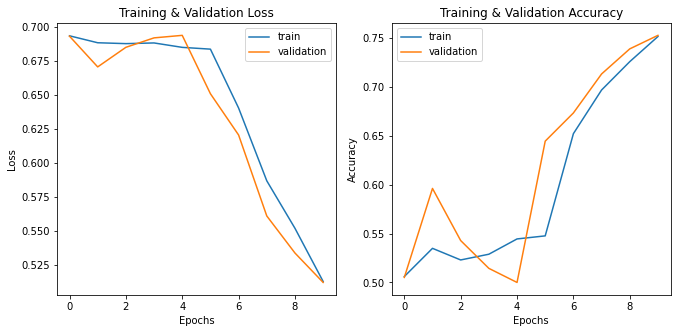

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        76.916701
Recall:    82.452243
Precision: 72.077670
Accuracy:  75.249944
---------(<class 'torch.nn.modules.rnn.LSTM'>, 2)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.323 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.693 | Train Acc: 53.365 | Val Acc: 50.059
Epoch 3 | Train Loss: 0.688 | Val Loss: 0.675 | Train Acc: 52.713 | Val Acc: 57.859
Epoch 4 | Train Loss: 0.669 | Val Loss: 0.66 | Train Acc: 58.485 | Val Acc: 61.394
Epoch 5 | Train Loss: 0.659 | Val Loss: 0.67 | Train Acc: 61.992 | Val Acc: 56.299
Epoch 6 | Train Loss: 0.667 | Val Loss: 0.664 | Train Acc: 59.758 | Val Acc: 60.841
Epoch 7 | Train Loss: 0.664 | Val Loss: 0.669 | Train Acc: 60.709 | Val Acc: 58.867
Epoch 8 | Train Loss: 0.665 | Val Loss: 0.678 | Train Acc: 60.74 | Val Acc: 58.096
Epoch 9 | Train Loss: 0.658 | Val Loss: 0.657 | Train Acc: 61.685 | Val Acc: 61.73
Epoch 10 | Train Loss: 0.655 | Val Loss: 

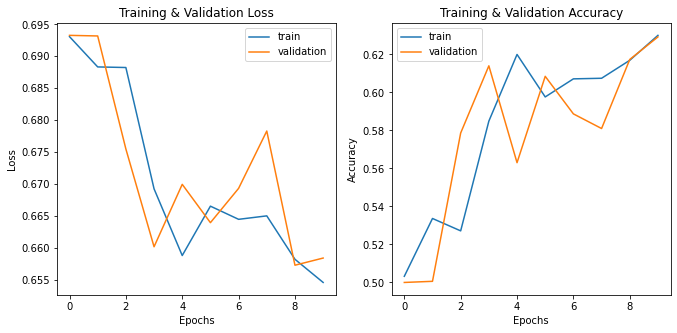

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        67.201252
Recall:    76.321635
Precision: 60.027952
Accuracy:  62.741613
---------(<class 'torch.nn.modules.rnn.LSTM'>, 5)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.315 | Val Acc: 51.126
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.68 | Train Acc: 53.435 | Val Acc: 54.542
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.128 | Val Acc: 50.908
Epoch 4 | Train Loss: 0.691 | Val Loss: 0.69 | Train Acc: 51.666 | Val Acc: 51.58
Epoch 5 | Train Loss: 0.688 | Val Loss: 0.691 | Train Acc: 53.336 | Val Acc: 51.975
Epoch 6 | Train Loss: 0.675 | Val Loss: 0.678 | Train Acc: 57.814 | Val Acc: 52.528
Epoch 7 | Train Loss: 0.675 | Val Loss: 0.689 | Train Acc: 56.736 | Val Acc: 53.436
Epoch 8 | Train Loss: 0.674 | Val Loss: 0.674 | Train Acc: 57.363 | Val Acc: 53.337
Epoch 9 | Train Loss: 0.664 | Val Loss: 0.67 | Train Acc: 60.675 | Val Acc: 60.545
Epoch 10 | Train Loss: 0.678 | Val Loss

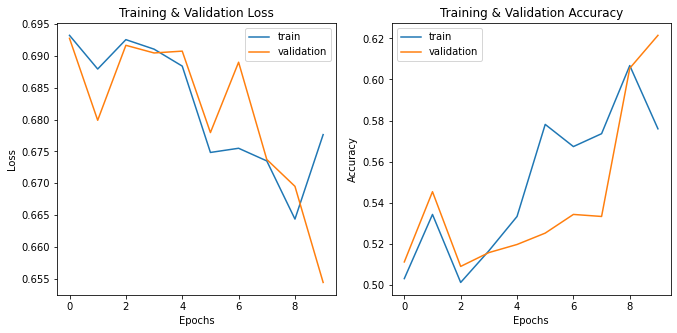

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        68.440233
Recall:    83.429587
Precision: 58.016682
Accuracy:  61.519662
---------(<class 'torch.nn.modules.rnn.LSTM'>, None)--------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.357 | Val Acc: 51.007
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.693 | Train Acc: 53.238 | Val Acc: 50.02
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.689 | Train Acc: 50.961 | Val Acc: 52.271
Epoch 4 | Train Loss: 0.674 | Val Loss: 0.663 | Train Acc: 57.89 | Val Acc: 58.788
Epoch 5 | Train Loss: 0.684 | Val Loss: 0.692 | Train Acc: 53.664 | Val Acc: 51.205
Epoch 6 | Train Loss: 0.668 | Val Loss: 0.693 | Train Acc: 58.545 | Val Acc: 53.357
Epoch 7 | Train Loss: 0.649 | Val Loss: 0.606 | Train Acc: 62.049 | Val Acc: 67.95
Epoch 8 | Train Loss: 0.641 | Val Loss: 0.596 | Train Acc: 63.903 | Val Acc: 68.76
Epoch 9 | Train Loss: 0.602 | Val Loss: 0.599 | Train Acc: 68.225 | Val Acc: 70.103
Epoch 10 | Train Loss: 0.576 | Val L

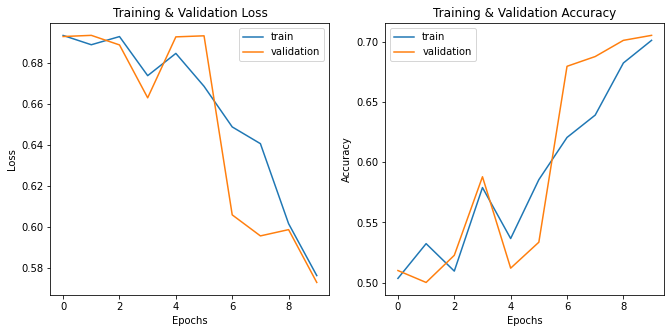

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        67.634955
Recall:    62.061306
Precision: 74.308511
Accuracy:  70.295490


In [ ]:
for c in [nn.GRU, nn.LSTM]:
  for gc in [-1,1,2,5,None]:
    print(f"---------{c,gc}--------")
    model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                p=0.5, cell_type=c).to(device)

    run_epochs(model, 10 , learning_rate=1e-4, clip=gc,
              train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
              show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

Gradient clipping seems to improve performance, so it will selected as a technique for the final model suggested for the task. Regarding the best out of all values tested, even though the LSTM results seem not so good (most likely due to the learning rate being too small), we can still see that 1 outperforms the rest of the values, so it will be selected.

### Dropout Probability


---


------ cell=<class 'torch.nn.modules.rnn.GRU'> | p=0.25 ------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.684 | Val Acc: 51.836
Epoch 2 | Train Loss: 0.669 | Val Loss: 0.576 | Train Acc: 56.437 | Val Acc: 71.327
Epoch 3 | Train Loss: 0.525 | Val Loss: 0.48 | Train Acc: 74.218 | Val Acc: 76.975
Epoch 4 | Train Loss: 0.434 | Val Loss: 0.508 | Train Acc: 79.951 | Val Acc: 77.054
Epoch 5 | Train Loss: 0.371 | Val Loss: 0.398 | Train Acc: 83.743 | Val Acc: 82.701
Epoch 6 | Train Loss: 0.339 | Val Loss: 0.372 | Train Acc: 85.269 | Val Acc: 83.551
Epoch 7 | Train Loss: 0.318 | Val Loss: 0.371 | Train Acc: 86.46 | Val Acc: 83.017
Epoch 8 | Train Loss: 0.293 | Val Loss: 0.361 | Train Acc: 87.865 | Val Acc: 84.419
Epoch 9 | Train Loss: 0.277 | Val Loss: 0.48 | Train Acc: 88.545 | Val Acc: 79.838
Epoch 10 | Train Loss: 0.259 | Val Loss: 0.375 | Train Acc: 89.335 | Val Acc: 83.116
-------------------------


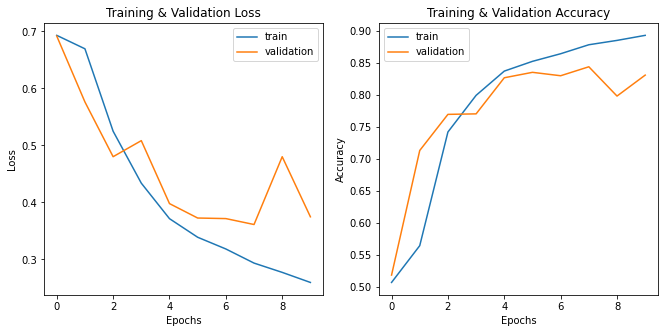

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        82.752121
Recall:    78.009773
Precision: 88.108379
Accuracy:  83.736947
------ cell=<class 'torch.nn.modules.rnn.GRU'> | p=0.5 ------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.309 | Val Acc: 51.758
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.683 | Train Acc: 52.766 | Val Acc: 55.865
Epoch 3 | Train Loss: 0.656 | Val Loss: 0.66 | Train Acc: 61.084 | Val Acc: 57.761
Epoch 4 | Train Loss: 0.597 | Val Loss: 0.554 | Train Acc: 69.325 | Val Acc: 72.472
Epoch 5 | Train Loss: 0.529 | Val Loss: 0.504 | Train Acc: 74.215 | Val Acc: 75.968
Epoch 6 | Train Loss: 0.464 | Val Loss: 0.452 | Train Acc: 78.36 | Val Acc: 78.811
Epoch 7 | Train Loss: 0.402 | Val Loss: 0.406 | Train Acc: 82.07 | Val Acc: 81.517
Epoch 8 | Train Loss: 0.361 | Val Loss: 0.39 | Train Acc: 84.132 | Val Acc: 82.148
Epoch 9 | Train Loss: 0.337 | Val Loss: 0.384 | Train Acc: 85.501 | Val Acc: 83.61
Epoch 10 | Train Loss: 0.314 | Val L

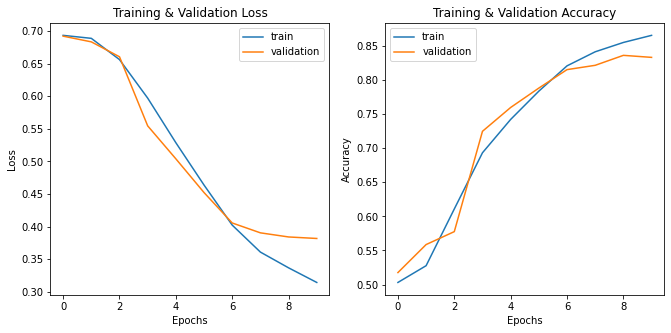

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        82.930265
Recall:    78.454020
Precision: 87.948207
Accuracy:  83.848034
------ cell=<class 'torch.nn.modules.rnn.GRU'> | p=0.75 ------
Epoch 1 | Train Loss: 0.695 | Val Loss: 0.693 | Train Acc: 49.903 | Val Acc: 50.632
Epoch 2 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.193 | Val Acc: 52.231
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.69 | Train Acc: 51.017 | Val Acc: 51.797
Epoch 4 | Train Loss: 0.689 | Val Loss: 0.653 | Train Acc: 53.37 | Val Acc: 64.692
Epoch 5 | Train Loss: 0.62 | Val Loss: 0.581 | Train Acc: 67.52 | Val Acc: 70.063
Epoch 6 | Train Loss: 0.584 | Val Loss: 0.559 | Train Acc: 69.585 | Val Acc: 72.512
Epoch 7 | Train Loss: 0.528 | Val Loss: 0.513 | Train Acc: 74.551 | Val Acc: 75.553
Epoch 8 | Train Loss: 0.482 | Val Loss: 0.475 | Train Acc: 77.409 | Val Acc: 76.975
Epoch 9 | Train Loss: 0.426 | Val Loss: 0.45 | Train Acc: 80.501 | Val Acc: 78.811
Epoch 10 | Train Loss: 0.375 | Val 

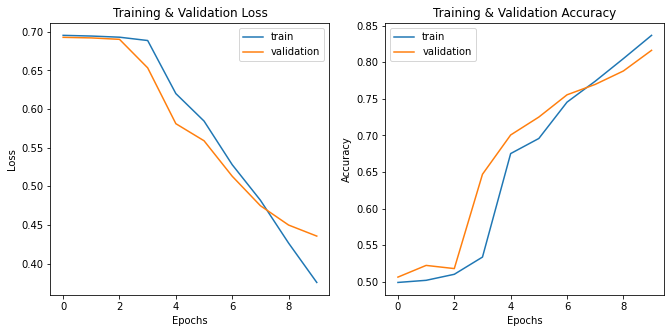

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        80.792827
Recall:    76.055087
Precision: 86.160040
Accuracy:  81.915130
------ cell=<class 'torch.nn.modules.rnn.LSTM'> | p=0.25 ------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.691 | Train Acc: 50.055 | Val Acc: 50.592
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.063 | Val Acc: 50.0
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.832 | Val Acc: 50.0
Epoch 4 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 49.86 | Val Acc: 50.0
Epoch 5 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 49.849 | Val Acc: 50.0
Epoch 6 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.038 | Val Acc: 50.0
Epoch 7 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.018 | Val Acc: 50.0
Epoch 8 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.402 | Val Acc: 50.316
Epoch 9 | Train Loss: 0.692 | Val Loss: 0.69 | Train Acc: 51.124 | Val Acc: 50.691
Epoch 10 | Train Loss: 0.692 | Val Loss: 0.

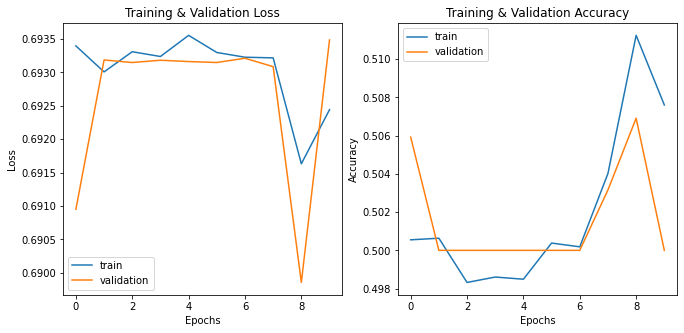

-------------------------
torch.Size([4501, 1])
torch.Size([4501])


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1:        0.000000
Recall:    0.000000
Precision: 0.000000
Accuracy:  49.988891
------ cell=<class 'torch.nn.modules.rnn.LSTM'> | p=0.5 ------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.694 | Train Acc: 50.574 | Val Acc: 50.178
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.278 | Val Acc: 50.0
Epoch 3 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 49.886 | Val Acc: 50.0
Epoch 4 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 49.798 | Val Acc: 50.0
Epoch 5 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 50.944 | Val Acc: 50.079
Epoch 6 | Train Loss: 0.691 | Val Loss: 0.702 | Train Acc: 51.965 | Val Acc: 50.0
Epoch 7 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.625 | Val Acc: 50.573
Epoch 8 | Train Loss: 0.692 | Val Loss: 0.691 | Train Acc: 51.632 | Val Acc: 51.876
Epoch 9 | Train Loss: 0.691 | Val Loss: 0.677 | Train Acc: 52.431 | Val Acc: 59.716
Epoch 10 | Train Loss: 0.687 | Val Loss: 0.693 | Train Acc: 54.109 | Val Acc: 51.027
-----------------------

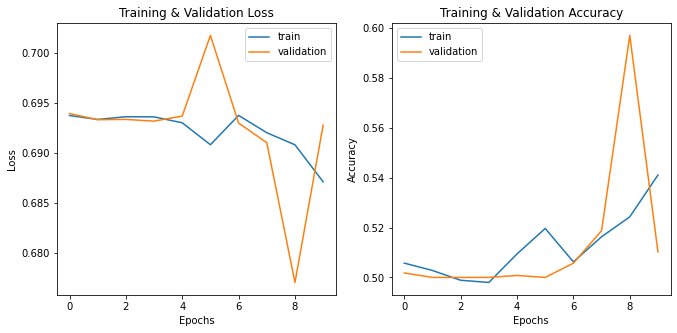

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        31.713244
Recall:    23.189693
Precision: 50.144092
Accuracy:  50.055543
------ cell=<class 'torch.nn.modules.rnn.LSTM'> | p=0.75 ------
Epoch 1 | Train Loss: 0.695 | Val Loss: 0.693 | Train Acc: 50.365 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 51.034 | Val Acc: 50.039
Epoch 3 | Train Loss: 0.692 | Val Loss: 0.688 | Train Acc: 51.83 | Val Acc: 52.982
Epoch 4 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 51.322 | Val Acc: 50.77
Epoch 5 | Train Loss: 0.691 | Val Loss: 0.692 | Train Acc: 52.081 | Val Acc: 51.639
Epoch 6 | Train Loss: 0.686 | Val Loss: 0.684 | Train Acc: 55.114 | Val Acc: 55.411
Epoch 7 | Train Loss: 0.681 | Val Loss: 0.68 | Train Acc: 56.699 | Val Acc: 56.971
Epoch 8 | Train Loss: 0.68 | Val Loss: 0.668 | Train Acc: 57.117 | Val Acc: 60.92
Epoch 9 | Train Loss: 0.66 | Val Loss: 0.684 | Train Acc: 61.112 | Val Acc: 50.0
Epoch 10 | Train Loss: 0.608 | Val Loss

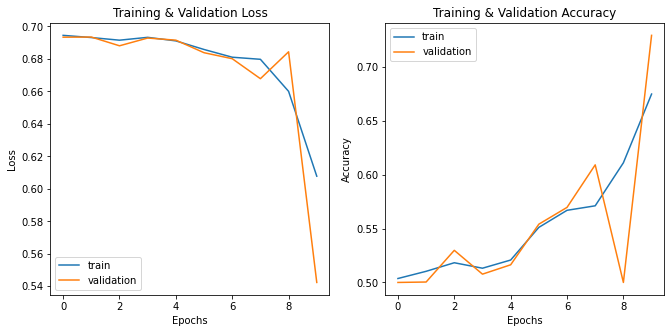

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        74.903969
Recall:    77.965349
Precision: 72.073922
Accuracy:  73.872473


In [ ]:
for c in [nn.GRU, nn.LSTM]:
  if c==nn.GRU:
    lr = 1e-4
  else: 
    lr = 1e-3
  for d in [0.25, 0.5, 0.75]:
      print(f'------ cell={c} | p={d} ------')
      model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                p=d, cell_type=c).to(device)

      run_epochs(model, 10 , learning_rate=lr, clip=1,
                train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)
      
      model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                p=d, cell_type=c).to(device)

      run_epochs(model, 10 , learning_rate=lr, clip=1,
                train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

As we can see above, the LSTM with 3 layers and 120 hidden size has not very good results, so I'm going to retrain to evaluate the dropout rate with 2 layers and hidden size of 80.

Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.535 | Val Acc: 49.941
Epoch 2 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 50.732 | Val Acc: 50.691
Epoch 3 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 51.215 | Val Acc: 50.355
Epoch 4 | Train Loss: 0.691 | Val Loss: 0.676 | Train Acc: 51.502 | Val Acc: 64.06
Epoch 5 | Train Loss: 0.486 | Val Loss: 0.381 | Train Acc: 76.706 | Val Acc: 83.748
Epoch 6 | Train Loss: 0.333 | Val Loss: 0.333 | Train Acc: 86.068 | Val Acc: 86.216
Epoch 7 | Train Loss: 0.266 | Val Loss: 0.338 | Train Acc: 89.329 | Val Acc: 86.177
Epoch 8 | Train Loss: 0.212 | Val Loss: 0.352 | Train Acc: 91.863 | Val Acc: 86.058
Epoch 9 | Train Loss: 0.172 | Val Loss: 0.391 | Train Acc: 93.378 | Val Acc: 83.906
Epoch 10 | Train Loss: 0.143 | Val Loss: 0.38 | Train Acc: 94.608 | Val Acc: 86.039
-------------------------


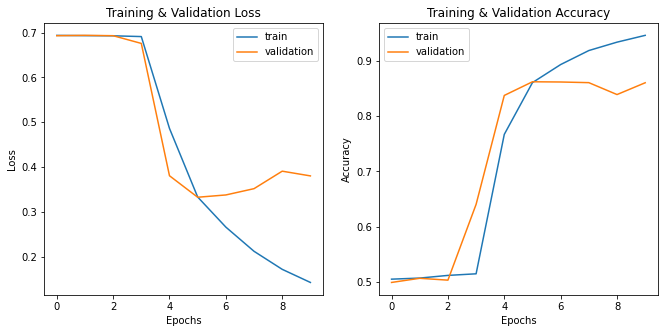

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.739991
Recall:    84.673478
Precision: 86.833713
Accuracy:  85.914241
Epoch 1 | Train Loss: 0.695 | Val Loss: 0.694 | Train Acc: 50.379 | Val Acc: 51.6
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.693 | Train Acc: 51.779 | Val Acc: 50.197
Epoch 3 | Train Loss: 0.694 | Val Loss: 0.696 | Train Acc: 50.899 | Val Acc: 49.961
Epoch 4 | Train Loss: 0.693 | Val Loss: 0.696 | Train Acc: 51.356 | Val Acc: 50.0
Epoch 5 | Train Loss: 0.691 | Val Loss: 0.667 | Train Acc: 52.01 | Val Acc: 59.321
Epoch 6 | Train Loss: 0.559 | Val Loss: 0.47 | Train Acc: 71.529 | Val Acc: 76.955
Epoch 7 | Train Loss: 0.43 | Val Loss: 0.448 | Train Acc: 80.73 | Val Acc: 78.416
Epoch 8 | Train Loss: 0.375 | Val Loss: 0.405 | Train Acc: 83.878 | Val Acc: 81.773
Epoch 9 | Train Loss: 0.323 | Val Loss: 0.411 | Train Acc: 86.471 | Val Acc: 81.852
Epoch 10 | Train Loss: 0.284 | Val Loss: 0.403 | Train Acc: 88.559 | Val Acc: 82.701
----------------

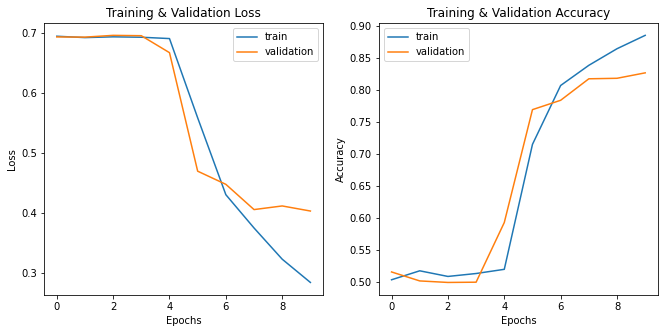

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.995704
Recall:    86.850289
Precision: 81.322795
Accuracy:  83.448123
Epoch 1 | Train Loss: 0.696 | Val Loss: 0.694 | Train Acc: 50.23 | Val Acc: 50.77
Epoch 2 | Train Loss: 0.695 | Val Loss: 0.694 | Train Acc: 50.219 | Val Acc: 49.941
Epoch 3 | Train Loss: 0.694 | Val Loss: 0.683 | Train Acc: 51.082 | Val Acc: 55.786
Epoch 4 | Train Loss: 0.692 | Val Loss: 0.693 | Train Acc: 52.14 | Val Acc: 50.375
Epoch 5 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 51.373 | Val Acc: 50.632
Epoch 6 | Train Loss: 0.663 | Val Loss: 0.635 | Train Acc: 60.438 | Val Acc: 62.836
Epoch 7 | Train Loss: 0.628 | Val Loss: 0.624 | Train Acc: 65.454 | Val Acc: 64.613
Epoch 8 | Train Loss: 0.597 | Val Loss: 0.566 | Train Acc: 70.048 | Val Acc: 73.065
Epoch 9 | Train Loss: 0.592 | Val Loss: 0.598 | Train Acc: 69.52 | Val Acc: 68.799
Epoch 10 | Train Loss: 0.536 | Val Loss: 0.499 | Train Acc: 74.37 | Val Acc: 76.165
-------------

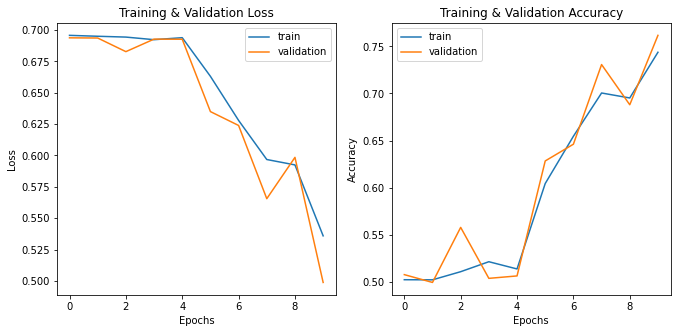

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        77.904520
Recall:    81.919147
Precision: 74.265002
Accuracy:  76.760720


In [ ]:
for d in [0.25, 0.5, 0.75]:
  model = SentimentClassifier(300, 80, pretrained_embeddings, num_of_layers=2, 
                                  p=d, cell_type=c).to(device)

  run_epochs(model, 10 , learning_rate=4e-3, clip=1,
          train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
          show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

From all the results about dropout probability, the larger probabilities produce worse results, so probabilities <= 5 seem the most appropriate. Also, in the GRU training we can how these probabilities help having smoother training (loss plot).

### Best Model Selection

Through trying different models as presented above, it can be noticed that the RNN with 3 layers and 120 hidden size has a consistenly good performance and not significantly overfitting/underfitting. So, this model will be further explored and fine-tuned. Note: In the results below mistakenly I added a loop for hidden size, but all results are with 120 hidden size. Unfortunately I didn't have time to rerun it, since it took a long time to execute.

--------(100, 0.3, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.588 | Val Acc: 51.619
Epoch 2 | Train Loss: 0.682 | Val Loss: 0.62 | Train Acc: 54.66 | Val Acc: 67.871
Epoch 3 | Train Loss: 0.643 | Val Loss: 0.576 | Train Acc: 62.083 | Val Acc: 70.024
Epoch 4 | Train Loss: 0.537 | Val Loss: 0.539 | Train Acc: 73.179 | Val Acc: 73.381
Epoch 5 | Train Loss: 0.47 | Val Loss: 0.488 | Train Acc: 77.429 | Val Acc: 77.409
Epoch 6 | Train Loss: 0.4 | Val Loss: 0.426 | Train Acc: 81.841 | Val Acc: 81.24
Epoch 7 | Train Loss: 0.357 | Val Loss: 0.464 | Train Acc: 84.321 | Val Acc: 79.463
Epoch 8 | Train Loss: 0.331 | Val Loss: 0.402 | Train Acc: 85.523 | Val Acc: 82.405
Epoch 9 | Train Loss: 0.308 | Val Loss: 0.378 | Train Acc: 86.875 | Val Acc: 83.57
Epoch 10 | Train Loss: 0.288 | Val Loss: 0.368 | Train Acc: 87.961 | Val Acc: 84.518
-------------------------


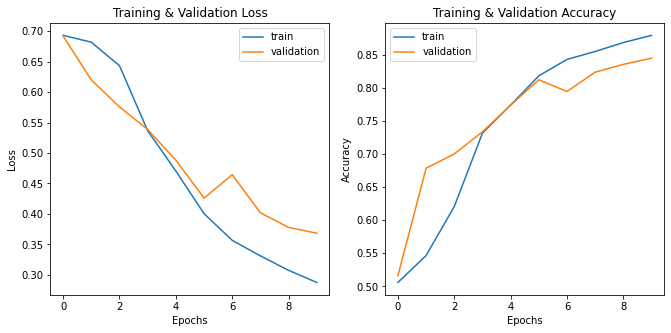

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.170774
Recall:    87.516659
Precision: 82.947368
Accuracy:  84.758942
--------(100, 0.3, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.727 | Val Acc: 51.758
Epoch 2 | Train Loss: 0.684 | Val Loss: 0.659 | Train Acc: 54.44 | Val Acc: 60.683
Epoch 3 | Train Loss: 0.677 | Val Loss: 0.675 | Train Acc: 56.194 | Val Acc: 56.655
Epoch 4 | Train Loss: 0.621 | Val Loss: 0.571 | Train Acc: 64.774 | Val Acc: 71.603
Epoch 5 | Train Loss: 0.499 | Val Loss: 0.502 | Train Acc: 76.246 | Val Acc: 76.975
Epoch 6 | Train Loss: 0.423 | Val Loss: 0.426 | Train Acc: 80.718 | Val Acc: 80.845
Epoch 7 | Train Loss: 0.374 | Val Loss: 0.397 | Train Acc: 83.399 | Val Acc: 82.287
Epoch 8 | Train Loss: 0.342 | Val Loss: 0.392 | Train Acc: 85.207 | Val Acc: 81.971
Epoch 9 | Train Loss: 0.323 | Val Loss: 0.397 | Train Acc: 86.127 | Val Acc: 82.464
Epoch 10 | Train Loss: 0.303 | Val Loss: 0.367 | Train Acc: 87.

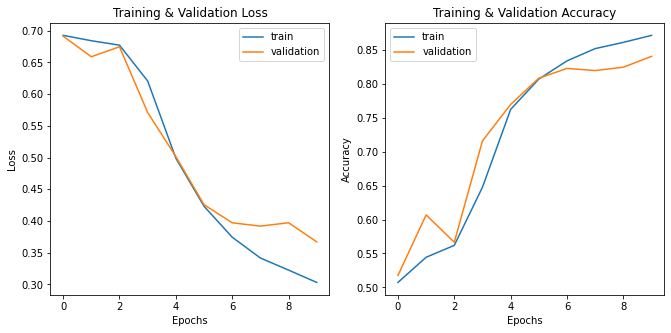

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.803815
Recall:    86.894713
Precision: 82.811177
Accuracy:  84.425683
--------(100, 0.3, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.769 | Val Acc: 50.849
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.687 | Train Acc: 53.523 | Val Acc: 53.298
Epoch 3 | Train Loss: 0.639 | Val Loss: 0.59 | Train Acc: 63.228 | Val Acc: 69.767
Epoch 4 | Train Loss: 0.563 | Val Loss: 0.544 | Train Acc: 71.766 | Val Acc: 72.828
Epoch 5 | Train Loss: 0.507 | Val Loss: 0.494 | Train Acc: 75.516 | Val Acc: 76.066
Epoch 6 | Train Loss: 0.444 | Val Loss: 0.436 | Train Acc: 79.468 | Val Acc: 79.463
Epoch 7 | Train Loss: 0.388 | Val Loss: 0.398 | Train Acc: 82.355 | Val Acc: 81.694
Epoch 8 | Train Loss: 0.353 | Val Loss: 0.379 | Train Acc: 84.795 | Val Acc: 83.412
Epoch 9 | Train Loss: 0.328 | Val Loss: 0.389 | Train Acc: 85.8 | Val Acc: 83.867
Epoch 10 | Train Loss: 0.306 | Val Loss: 0.366 | Train Acc: 86

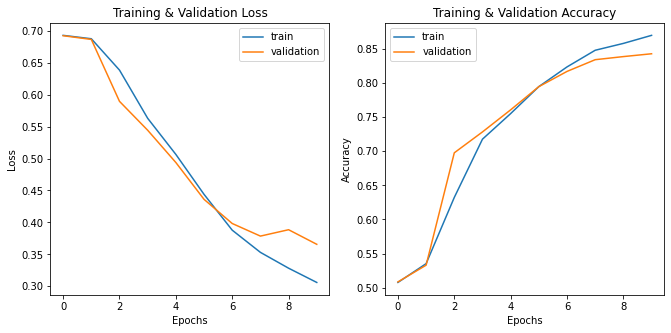

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.189189
Recall:    87.516659
Precision: 82.982308
Accuracy:  84.781160
--------(100, 0.4, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.667 | Val Acc: 50.237
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.694 | Train Acc: 52.527 | Val Acc: 54.463
Epoch 3 | Train Loss: 0.667 | Val Loss: 0.637 | Train Acc: 57.972 | Val Acc: 66.449
Epoch 4 | Train Loss: 0.574 | Val Loss: 0.584 | Train Acc: 70.942 | Val Acc: 69.589
Epoch 5 | Train Loss: 0.516 | Val Loss: 0.496 | Train Acc: 74.779 | Val Acc: 76.165
Epoch 6 | Train Loss: 0.455 | Val Loss: 0.443 | Train Acc: 78.673 | Val Acc: 79.443
Epoch 7 | Train Loss: 0.392 | Val Loss: 0.401 | Train Acc: 82.343 | Val Acc: 81.576
Epoch 8 | Train Loss: 0.351 | Val Loss: 0.505 | Train Acc: 84.547 | Val Acc: 77.192
Epoch 9 | Train Loss: 0.33 | Val Loss: 0.374 | Train Acc: 85.721 | Val Acc: 83.886
Epoch 10 | Train Loss: 0.306 | Val Loss: 0.366 | Train Acc: 87.

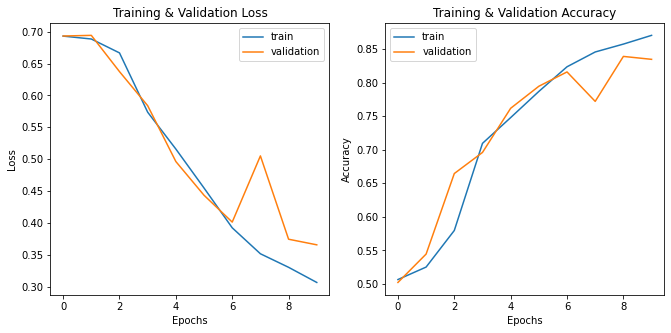

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.638895
Recall:    80.053310
Precision: 87.560739
Accuracy:  84.336814
--------(100, 0.4, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.233 | Val Acc: 51.086
Epoch 2 | Train Loss: 0.687 | Val Loss: 0.689 | Train Acc: 53.328 | Val Acc: 52.093
Epoch 3 | Train Loss: 0.679 | Val Loss: 0.607 | Train Acc: 55.317 | Val Acc: 67.871
Epoch 4 | Train Loss: 0.591 | Val Loss: 0.562 | Train Acc: 68.885 | Val Acc: 71.485
Epoch 5 | Train Loss: 0.546 | Val Loss: 0.524 | Train Acc: 72.268 | Val Acc: 74.032
Epoch 6 | Train Loss: 0.488 | Val Loss: 0.493 | Train Acc: 76.28 | Val Acc: 76.382
Epoch 7 | Train Loss: 0.43 | Val Loss: 0.43 | Train Acc: 79.815 | Val Acc: 80.154
Epoch 8 | Train Loss: 0.373 | Val Loss: 0.4 | Train Acc: 83.526 | Val Acc: 82.326
Epoch 9 | Train Loss: 0.339 | Val Loss: 0.377 | Train Acc: 85.326 | Val Acc: 83.59
Epoch 10 | Train Loss: 0.316 | Val Loss: 0.399 | Train Acc: 86.553 |

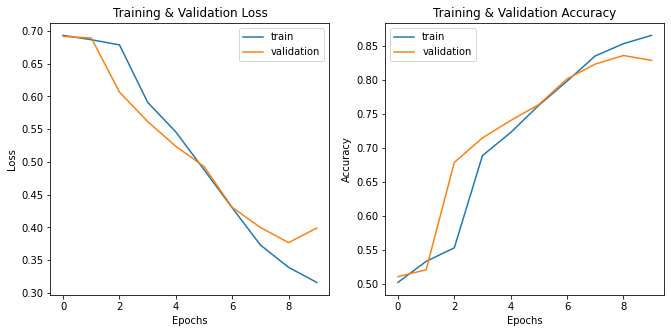

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.735202
Recall:    90.626388
Precision: 79.563183
Accuracy:  83.670295
--------(100, 0.4, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.694 | Train Acc: 50.935 | Val Acc: 50.217
Epoch 2 | Train Loss: 0.685 | Val Loss: 0.655 | Train Acc: 53.413 | Val Acc: 65.482
Epoch 3 | Train Loss: 0.537 | Val Loss: 0.506 | Train Acc: 73.735 | Val Acc: 74.941
Epoch 4 | Train Loss: 0.431 | Val Loss: 0.421 | Train Acc: 80.419 | Val Acc: 80.944
Epoch 5 | Train Loss: 0.369 | Val Loss: 0.386 | Train Acc: 83.904 | Val Acc: 82.662
Epoch 6 | Train Loss: 0.335 | Val Loss: 0.379 | Train Acc: 85.755 | Val Acc: 83.215
Epoch 7 | Train Loss: 0.315 | Val Loss: 0.429 | Train Acc: 86.612 | Val Acc: 81.023
Epoch 8 | Train Loss: 0.303 | Val Loss: 0.373 | Train Acc: 87.292 | Val Acc: 84.893
Epoch 9 | Train Loss: 0.283 | Val Loss: 0.369 | Train Acc: 88.373 | Val Acc: 84.044
Epoch 10 | Train Loss: 0.269 | Val Loss: 0.384 | Train Acc:

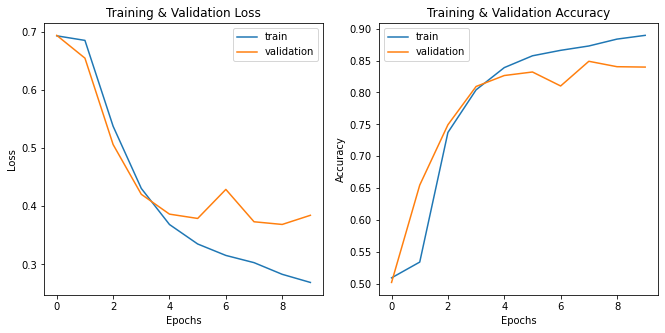

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.255354
Recall:    91.959129
Precision: 79.462572
Accuracy:  84.092424
--------(100, 0.5, 1)---------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 49.818 | Val Acc: 51.679
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.688 | Train Acc: 52.202 | Val Acc: 52.409
Epoch 3 | Train Loss: 0.577 | Val Loss: 0.522 | Train Acc: 69.472 | Val Acc: 74.862
Epoch 4 | Train Loss: 0.46 | Val Loss: 0.433 | Train Acc: 78.583 | Val Acc: 79.917
Epoch 5 | Train Loss: 0.387 | Val Loss: 0.399 | Train Acc: 82.812 | Val Acc: 81.833
Epoch 6 | Train Loss: 0.35 | Val Loss: 0.377 | Train Acc: 84.863 | Val Acc: 83.393
Epoch 7 | Train Loss: 0.326 | Val Loss: 0.383 | Train Acc: 86.017 | Val Acc: 83.59
Epoch 8 | Train Loss: 0.307 | Val Loss: 0.362 | Train Acc: 87.191 | Val Acc: 84.301
Epoch 9 | Train Loss: 0.288 | Val Loss: 0.355 | Train Acc: 88.116 | Val Acc: 84.953
Epoch 10 | Train Loss: 0.276 | Val Loss: 0.4 | Train Acc: 88.754 |

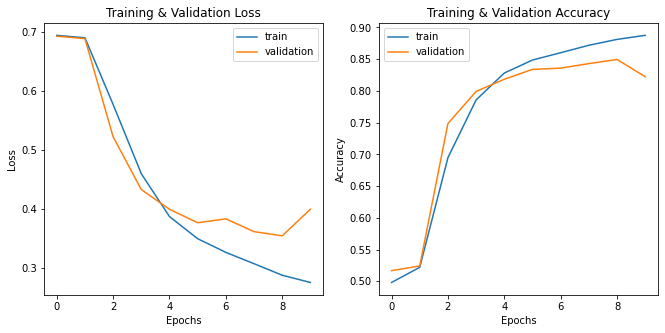

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.296208
Recall:    94.313638
Precision: 76.202441
Accuracy:  82.426128
--------(100, 0.5, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.848 | Val Acc: 52.093
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.684 | Train Acc: 53.034 | Val Acc: 54.66
Epoch 3 | Train Loss: 0.659 | Val Loss: 0.686 | Train Acc: 60.839 | Val Acc: 54.186
Epoch 4 | Train Loss: 0.596 | Val Loss: 0.567 | Train Acc: 68.36 | Val Acc: 71.327
Epoch 5 | Train Loss: 0.535 | Val Loss: 0.536 | Train Acc: 73.718 | Val Acc: 74.901
Epoch 6 | Train Loss: 0.479 | Val Loss: 0.465 | Train Acc: 77.104 | Val Acc: 79.127
Epoch 7 | Train Loss: 0.42 | Val Loss: 0.408 | Train Acc: 80.747 | Val Acc: 80.983
Epoch 8 | Train Loss: 0.378 | Val Loss: 0.395 | Train Acc: 83.001 | Val Acc: 82.682
Epoch 9 | Train Loss: 0.347 | Val Loss: 0.506 | Train Acc: 84.877 | Val Acc: 80.49
Epoch 10 | Train Loss: 0.319 | Val Loss: 0.475 | Train Acc: 86.488

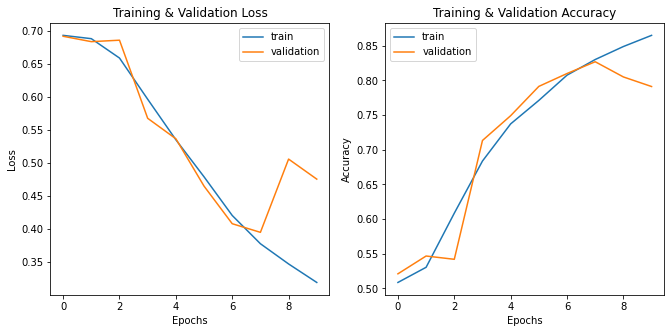

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        77.671903
Recall:    66.992448
Precision: 92.401961
Accuracy:  80.737614
--------(100, 0.5, None)---------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.086 | Val Acc: 51.955
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.687 | Train Acc: 52.005 | Val Acc: 53.416
Epoch 3 | Train Loss: 0.597 | Val Loss: 0.512 | Train Acc: 66.885 | Val Acc: 75.316
Epoch 4 | Train Loss: 0.471 | Val Loss: 0.446 | Train Acc: 77.872 | Val Acc: 79.206
Epoch 5 | Train Loss: 0.397 | Val Loss: 0.409 | Train Acc: 82.287 | Val Acc: 81.023
Epoch 6 | Train Loss: 0.359 | Val Loss: 0.382 | Train Acc: 84.491 | Val Acc: 82.859
Epoch 7 | Train Loss: 0.333 | Val Loss: 0.366 | Train Acc: 85.898 | Val Acc: 83.748
Epoch 8 | Train Loss: 0.313 | Val Loss: 0.431 | Train Acc: 86.672 | Val Acc: 82.385
Epoch 9 | Train Loss: 0.295 | Val Loss: 0.374 | Train Acc: 87.605 | Val Acc: 84.34
Epoch 10 | Train Loss: 0.281 | Val Loss: 0.374 | Train Acc: 8

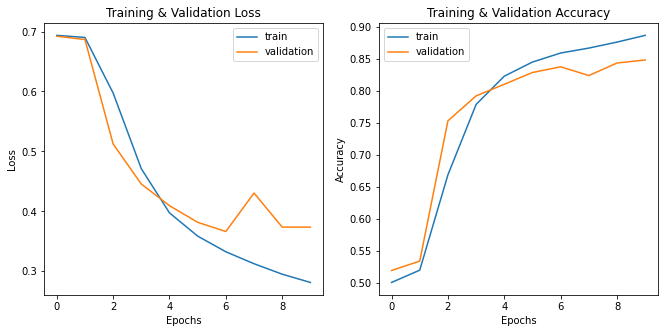

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.056453
Recall:    85.339849
Precision: 84.774934
Accuracy:  85.003333
--------(120, 0.3, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.557 | Val Acc: 50.711
Epoch 2 | Train Loss: 0.686 | Val Loss: 0.673 | Train Acc: 53.192 | Val Acc: 63.902
Epoch 3 | Train Loss: 0.632 | Val Loss: 0.532 | Train Acc: 62.605 | Val Acc: 74.013
Epoch 4 | Train Loss: 0.48 | Val Loss: 0.469 | Train Acc: 77.048 | Val Acc: 77.765
Epoch 5 | Train Loss: 0.399 | Val Loss: 0.4 | Train Acc: 81.807 | Val Acc: 81.655
Epoch 6 | Train Loss: 0.351 | Val Loss: 0.374 | Train Acc: 84.606 | Val Acc: 83.116
Epoch 7 | Train Loss: 0.323 | Val Loss: 0.373 | Train Acc: 86.076 | Val Acc: 83.748
Epoch 8 | Train Loss: 0.3 | Val Loss: 0.359 | Train Acc: 87.115 | Val Acc: 83.807
Epoch 9 | Train Loss: 0.283 | Val Loss: 0.362 | Train Acc: 88.147 | Val Acc: 84.538
Epoch 10 | Train Loss: 0.266 | Val Loss: 0.388 | Train Acc: 89.039 

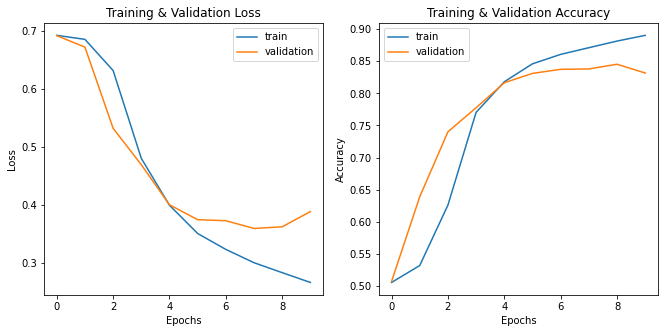

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        81.308636
Recall:    75.077743
Precision: 88.667366
Accuracy:  82.737170
--------(120, 0.3, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.679 | Val Acc: 51.876
Epoch 2 | Train Loss: 0.687 | Val Loss: 0.677 | Train Acc: 53.037 | Val Acc: 57.227
Epoch 3 | Train Loss: 0.545 | Val Loss: 0.49 | Train Acc: 73.086 | Val Acc: 76.758
Epoch 4 | Train Loss: 0.441 | Val Loss: 0.429 | Train Acc: 79.584 | Val Acc: 79.996
Epoch 5 | Train Loss: 0.377 | Val Loss: 0.4 | Train Acc: 83.413 | Val Acc: 81.675
Epoch 6 | Train Loss: 0.345 | Val Loss: 0.389 | Train Acc: 84.996 | Val Acc: 82.464
Epoch 7 | Train Loss: 0.322 | Val Loss: 0.381 | Train Acc: 86.404 | Val Acc: 83.077
Epoch 8 | Train Loss: 0.302 | Val Loss: 0.379 | Train Acc: 87.337 | Val Acc: 83.63
Epoch 9 | Train Loss: 0.285 | Val Loss: 0.368 | Train Acc: 88.221 | Val Acc: 84.301
Epoch 10 | Train Loss: 0.266 | Val Loss: 0.374 | Train Acc: 89.118

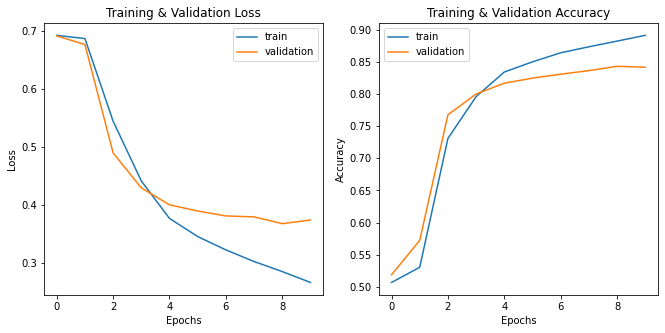

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.753465
Recall:    82.852066
Precision: 86.744186
Accuracy:  85.092202
--------(120, 0.3, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.571 | Val Acc: 51.975
Epoch 2 | Train Loss: 0.66 | Val Loss: 0.556 | Train Acc: 57.521 | Val Acc: 72.117
Epoch 3 | Train Loss: 0.51 | Val Loss: 0.478 | Train Acc: 75.564 | Val Acc: 77.152
Epoch 4 | Train Loss: 0.421 | Val Loss: 0.437 | Train Acc: 80.608 | Val Acc: 80.233
Epoch 5 | Train Loss: 0.366 | Val Loss: 0.395 | Train Acc: 84.011 | Val Acc: 82.603
Epoch 6 | Train Loss: 0.334 | Val Loss: 0.407 | Train Acc: 85.492 | Val Acc: 81.852
Epoch 7 | Train Loss: 0.315 | Val Loss: 0.368 | Train Acc: 86.714 | Val Acc: 84.261
Epoch 8 | Train Loss: 0.292 | Val Loss: 0.366 | Train Acc: 87.907 | Val Acc: 84.479
Epoch 9 | Train Loss: 0.283 | Val Loss: 0.391 | Train Acc: 88.243 | Val Acc: 84.143
Epoch 10 | Train Loss: 0.263 | Val Loss: 0.368 | Train Acc: 8

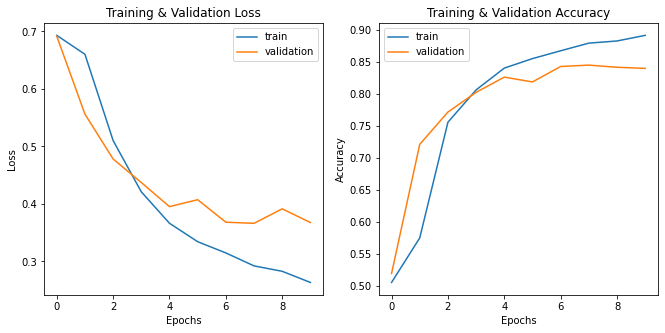

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.474286
Recall:    81.119502
Precision: 85.969868
Accuracy:  83.936903
--------(120, 0.4, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.422 | Val Acc: 52.014
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.671 | Train Acc: 52.809 | Val Acc: 56.615
Epoch 3 | Train Loss: 0.54 | Val Loss: 0.49 | Train Acc: 73.264 | Val Acc: 76.679
Epoch 4 | Train Loss: 0.441 | Val Loss: 0.451 | Train Acc: 80.033 | Val Acc: 79.522
Epoch 5 | Train Loss: 0.383 | Val Loss: 0.398 | Train Acc: 83.162 | Val Acc: 81.833
Epoch 6 | Train Loss: 0.345 | Val Loss: 0.388 | Train Acc: 85.004 | Val Acc: 83.748
Epoch 7 | Train Loss: 0.321 | Val Loss: 0.413 | Train Acc: 86.412 | Val Acc: 82.109
Epoch 8 | Train Loss: 0.303 | Val Loss: 0.365 | Train Acc: 87.32 | Val Acc: 85.19
Epoch 9 | Train Loss: 0.287 | Val Loss: 0.371 | Train Acc: 88.102 | Val Acc: 84.933
Epoch 10 | Train Loss: 0.272 | Val Loss: 0.388 | Train Acc: 88.875

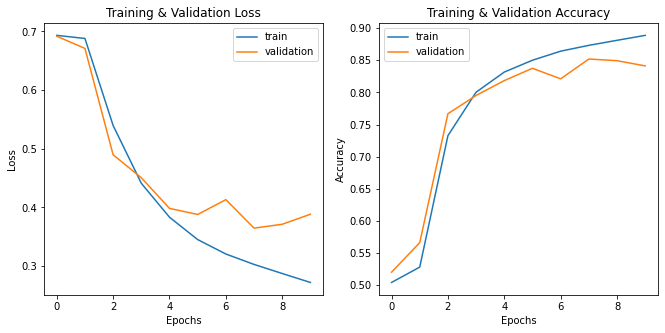

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.426704
Recall:    79.386939
Precision: 87.899656
Accuracy:  84.225728
--------(120, 0.4, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.498 | Val Acc: 51.876
Epoch 2 | Train Loss: 0.678 | Val Loss: 0.611 | Train Acc: 54.648 | Val Acc: 69.036
Epoch 3 | Train Loss: 0.538 | Val Loss: 0.496 | Train Acc: 73.538 | Val Acc: 75.928
Epoch 4 | Train Loss: 0.446 | Val Loss: 0.436 | Train Acc: 79.415 | Val Acc: 79.72
Epoch 5 | Train Loss: 0.384 | Val Loss: 0.394 | Train Acc: 83.091 | Val Acc: 82.168
Epoch 6 | Train Loss: 0.347 | Val Loss: 0.532 | Train Acc: 84.993 | Val Acc: 74.961
Epoch 7 | Train Loss: 0.324 | Val Loss: 0.372 | Train Acc: 86.127 | Val Acc: 83.551
Epoch 8 | Train Loss: 0.302 | Val Loss: 0.373 | Train Acc: 87.453 | Val Acc: 84.301
Epoch 9 | Train Loss: 0.287 | Val Loss: 0.376 | Train Acc: 88.057 | Val Acc: 83.472
Epoch 10 | Train Loss: 0.271 | Val Loss: 0.365 | Train Acc: 88.

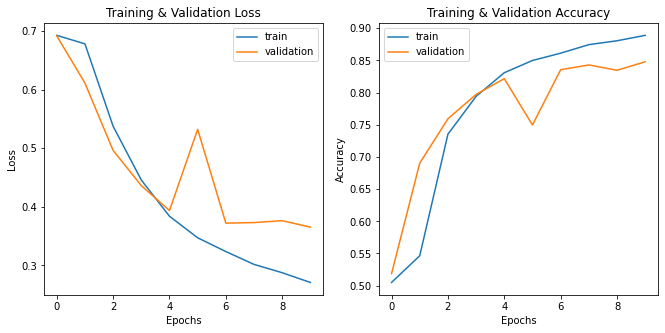

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.109087
Recall:    89.249223
Precision: 81.336032
Accuracy:  84.381249
--------(120, 0.4, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.58 | Val Acc: 52.014
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.683 | Train Acc: 52.465 | Val Acc: 53.772
Epoch 3 | Train Loss: 0.651 | Val Loss: 0.592 | Train Acc: 61.575 | Val Acc: 70.083
Epoch 4 | Train Loss: 0.547 | Val Loss: 0.54 | Train Acc: 72.985 | Val Acc: 73.776
Epoch 5 | Train Loss: 0.475 | Val Loss: 0.455 | Train Acc: 77.708 | Val Acc: 78.239
Epoch 6 | Train Loss: 0.414 | Val Loss: 0.421 | Train Acc: 81.322 | Val Acc: 80.529
Epoch 7 | Train Loss: 0.367 | Val Loss: 0.39 | Train Acc: 83.89 | Val Acc: 81.951
Epoch 8 | Train Loss: 0.336 | Val Loss: 0.396 | Train Acc: 85.515 | Val Acc: 82.8
Epoch 9 | Train Loss: 0.316 | Val Loss: 0.378 | Train Acc: 86.612 | Val Acc: 82.701
Epoch 10 | Train Loss: 0.3 | Val Loss: 0.365 | Train Acc: 87.32 |

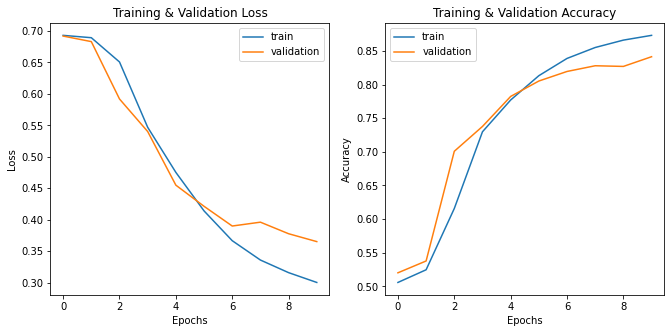

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.652808
Recall:    85.028876
Precision: 84.280053
Accuracy:  84.581204
--------(120, 0.5, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.408 | Val Acc: 51.422
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.693 | Train Acc: 52.284 | Val Acc: 53.002
Epoch 3 | Train Loss: 0.588 | Val Loss: 0.545 | Train Acc: 67.98 | Val Acc: 74.862
Epoch 4 | Train Loss: 0.462 | Val Loss: 0.49 | Train Acc: 78.439 | Val Acc: 75.987
Epoch 5 | Train Loss: 0.393 | Val Loss: 0.412 | Train Acc: 82.583 | Val Acc: 81.694
Epoch 6 | Train Loss: 0.353 | Val Loss: 0.383 | Train Acc: 84.629 | Val Acc: 83.274
Epoch 7 | Train Loss: 0.326 | Val Loss: 0.369 | Train Acc: 85.851 | Val Acc: 83.886
Epoch 8 | Train Loss: 0.307 | Val Loss: 0.371 | Train Acc: 87.024 | Val Acc: 83.393
Epoch 9 | Train Loss: 0.29 | Val Loss: 0.39 | Train Acc: 87.93 | Val Acc: 84.34
Epoch 10 | Train Loss: 0.277 | Val Loss: 0.374 | Train Acc: 88.542 |

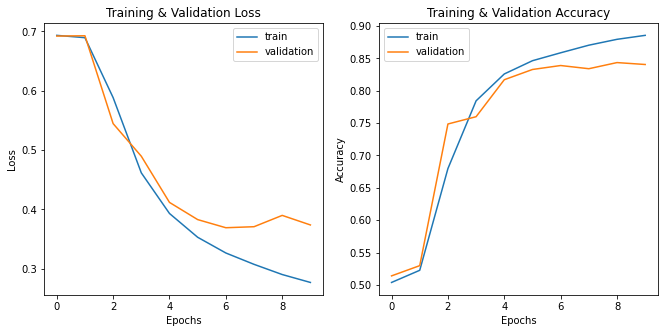

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.690129
Recall:    90.048867
Precision: 81.733871
Accuracy:  84.958898
--------(120, 0.5, 5)---------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 50.54 | Val Acc: 51.244
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.662 | Train Acc: 52.8 | Val Acc: 58.768
Epoch 3 | Train Loss: 0.55 | Val Loss: 0.491 | Train Acc: 72.83 | Val Acc: 76.205
Epoch 4 | Train Loss: 0.444 | Val Loss: 0.423 | Train Acc: 79.669 | Val Acc: 80.45
Epoch 5 | Train Loss: 0.379 | Val Loss: 0.4 | Train Acc: 83.156 | Val Acc: 81.793
Epoch 6 | Train Loss: 0.345 | Val Loss: 0.391 | Train Acc: 85.148 | Val Acc: 82.721
Epoch 7 | Train Loss: 0.322 | Val Loss: 0.389 | Train Acc: 86.387 | Val Acc: 82.682
Epoch 8 | Train Loss: 0.303 | Val Loss: 0.375 | Train Acc: 87.225 | Val Acc: 83.61
Epoch 9 | Train Loss: 0.286 | Val Loss: 0.362 | Train Acc: 88.048 | Val Acc: 84.755
Epoch 10 | Train Loss: 0.271 | Val Loss: 0.356 | Train Acc: 88.793 | Va

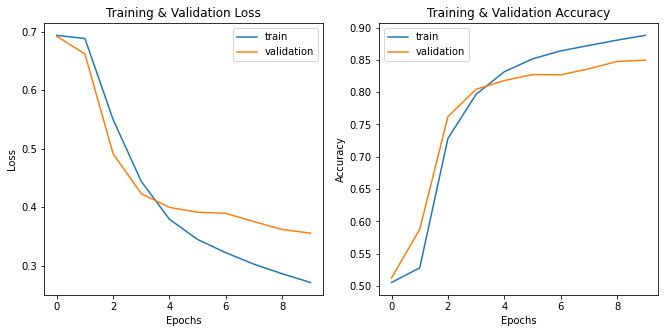

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.905750
Recall:    88.271879
Precision: 83.663158
Accuracy:  85.514330
--------(120, 0.5, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.653 | Val Acc: 51.935
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.685 | Train Acc: 52.301 | Val Acc: 53.574
Epoch 3 | Train Loss: 0.667 | Val Loss: 0.639 | Train Acc: 60.362 | Val Acc: 64.81
Epoch 4 | Train Loss: 0.672 | Val Loss: 0.681 | Train Acc: 58.567 | Val Acc: 54.404
Epoch 5 | Train Loss: 0.626 | Val Loss: 0.58 | Train Acc: 64.893 | Val Acc: 69.431
Epoch 6 | Train Loss: 0.551 | Val Loss: 0.526 | Train Acc: 72.322 | Val Acc: 74.269
Epoch 7 | Train Loss: 0.491 | Val Loss: 0.468 | Train Acc: 76.323 | Val Acc: 77.903
Epoch 8 | Train Loss: 0.423 | Val Loss: 0.409 | Train Acc: 80.673 | Val Acc: 81.161
Epoch 9 | Train Loss: 0.371 | Val Loss: 0.388 | Train Acc: 83.421 | Val Acc: 81.971
Epoch 10 | Train Loss: 0.337 | Val Loss: 0.402 | Train Acc: 85

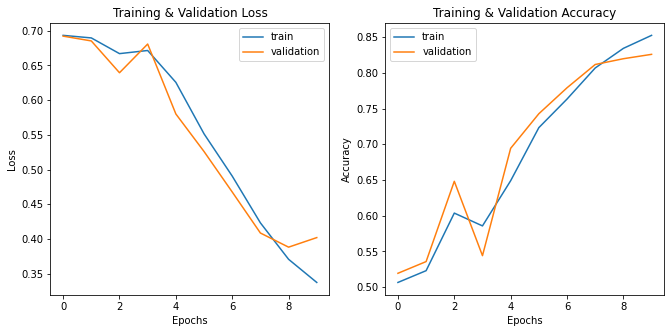

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.965133
Recall:    92.003554
Precision: 77.218494
Accuracy:  82.426128
--------(140, 0.3, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.755 | Val Acc: 51.836
Epoch 2 | Train Loss: 0.671 | Val Loss: 0.572 | Train Acc: 56.048 | Val Acc: 71.189
Epoch 3 | Train Loss: 0.52 | Val Loss: 0.484 | Train Acc: 74.765 | Val Acc: 77.449
Epoch 4 | Train Loss: 0.428 | Val Loss: 0.434 | Train Acc: 80.436 | Val Acc: 79.838
Epoch 5 | Train Loss: 0.371 | Val Loss: 0.437 | Train Acc: 83.706 | Val Acc: 80.924
Epoch 6 | Train Loss: 0.342 | Val Loss: 0.376 | Train Acc: 85.281 | Val Acc: 83.63
Epoch 7 | Train Loss: 0.317 | Val Loss: 0.376 | Train Acc: 86.426 | Val Acc: 83.709
Epoch 8 | Train Loss: 0.299 | Val Loss: 0.389 | Train Acc: 87.487 | Val Acc: 82.484
Epoch 9 | Train Loss: 0.284 | Val Loss: 0.367 | Train Acc: 88.116 | Val Acc: 83.788
Epoch 10 | Train Loss: 0.266 | Val Loss: 0.371 | Train Acc: 89.1

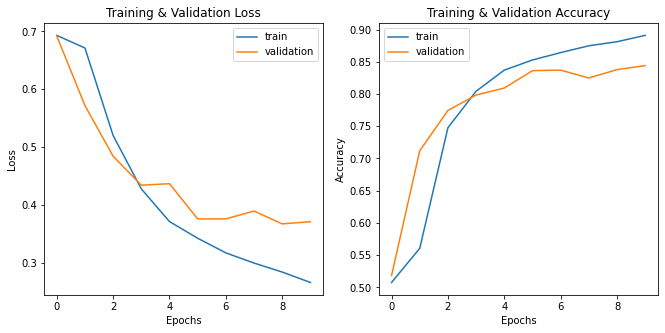

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.988355
Recall:    89.160373
Precision: 81.189320
Accuracy:  84.247945
--------(140, 0.3, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.825 | Val Acc: 50.592
Epoch 2 | Train Loss: 0.683 | Val Loss: 0.66 | Train Acc: 53.839 | Val Acc: 61.019
Epoch 3 | Train Loss: 0.539 | Val Loss: 0.495 | Train Acc: 73.177 | Val Acc: 75.711
Epoch 4 | Train Loss: 0.438 | Val Loss: 0.432 | Train Acc: 80.038 | Val Acc: 80.628
Epoch 5 | Train Loss: 0.378 | Val Loss: 0.396 | Train Acc: 83.458 | Val Acc: 82.563
Epoch 6 | Train Loss: 0.343 | Val Loss: 0.381 | Train Acc: 85.128 | Val Acc: 83.432
Epoch 7 | Train Loss: 0.323 | Val Loss: 0.391 | Train Acc: 86.327 | Val Acc: 83.195
Epoch 8 | Train Loss: 0.302 | Val Loss: 0.393 | Train Acc: 87.428 | Val Acc: 84.36
Epoch 9 | Train Loss: 0.282 | Val Loss: 0.382 | Train Acc: 88.316 | Val Acc: 83.728
Epoch 10 | Train Loss: 0.27 | Val Loss: 0.402 | Train Acc: 89.01

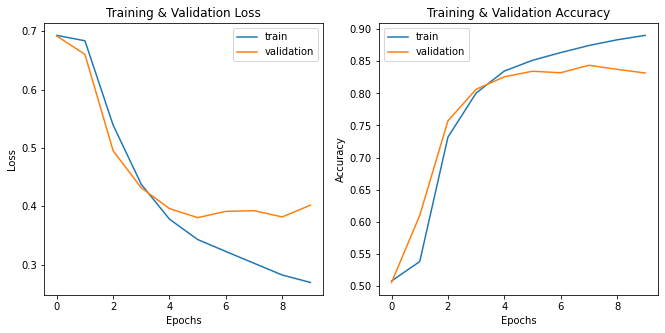

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        82.945189
Recall:    78.320746
Precision: 88.150000
Accuracy:  83.892468
--------(140, 0.3, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.691 | Train Acc: 50.749 | Val Acc: 52.113
Epoch 2 | Train Loss: 0.663 | Val Loss: 0.575 | Train Acc: 57.591 | Val Acc: 71.781
Epoch 3 | Train Loss: 0.515 | Val Loss: 0.493 | Train Acc: 75.033 | Val Acc: 76.619
Epoch 4 | Train Loss: 0.427 | Val Loss: 0.421 | Train Acc: 80.388 | Val Acc: 80.549
Epoch 5 | Train Loss: 0.374 | Val Loss: 0.399 | Train Acc: 83.447 | Val Acc: 81.675
Epoch 6 | Train Loss: 0.339 | Val Loss: 0.37 | Train Acc: 85.419 | Val Acc: 83.156
Epoch 7 | Train Loss: 0.315 | Val Loss: 0.364 | Train Acc: 86.745 | Val Acc: 84.163
Epoch 8 | Train Loss: 0.301 | Val Loss: 0.374 | Train Acc: 87.524 | Val Acc: 84.321
Epoch 9 | Train Loss: 0.282 | Val Loss: 0.386 | Train Acc: 88.347 | Val Acc: 83.116
Epoch 10 | Train Loss: 0.268 | Val Loss: 0.366 | Train Acc: 

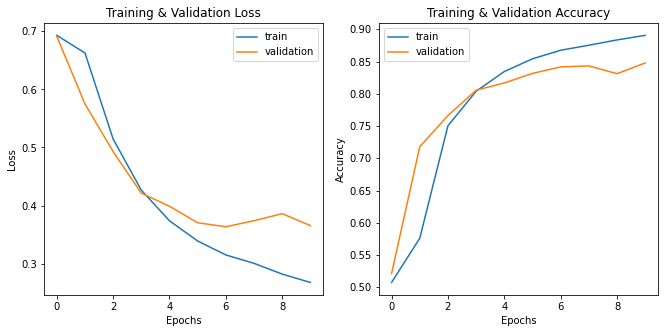

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.599322
Recall:    89.782319
Precision: 81.788749
Accuracy:  84.892246
--------(140, 0.4, 1)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.323 | Val Acc: 51.738
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.68 | Train Acc: 52.724 | Val Acc: 55.075
Epoch 3 | Train Loss: 0.624 | Val Loss: 0.577 | Train Acc: 67.514 | Val Acc: 70.893
Epoch 4 | Train Loss: 0.542 | Val Loss: 0.516 | Train Acc: 73.385 | Val Acc: 74.763
Epoch 5 | Train Loss: 0.474 | Val Loss: 0.457 | Train Acc: 77.815 | Val Acc: 78.377
Epoch 6 | Train Loss: 0.409 | Val Loss: 0.417 | Train Acc: 81.613 | Val Acc: 81.497
Epoch 7 | Train Loss: 0.363 | Val Loss: 0.463 | Train Acc: 84.113 | Val Acc: 77.942
Epoch 8 | Train Loss: 0.337 | Val Loss: 0.383 | Train Acc: 85.557 | Val Acc: 83.669
Epoch 9 | Train Loss: 0.316 | Val Loss: 0.364 | Train Acc: 86.714 | Val Acc: 84.123
Epoch 10 | Train Loss: 0.299 | Val Loss: 0.364 | Train Acc: 87.

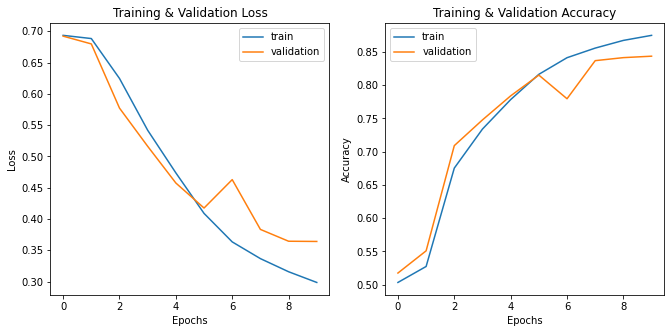

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.282864
Recall:    84.451355
Precision: 84.115044
Accuracy:  84.247945
--------(140, 0.4, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.605 | Val Acc: 50.533
Epoch 2 | Train Loss: 0.689 | Val Loss: 0.683 | Train Acc: 52.902 | Val Acc: 54.7
Epoch 3 | Train Loss: 0.578 | Val Loss: 0.526 | Train Acc: 70.141 | Val Acc: 73.934
Epoch 4 | Train Loss: 0.464 | Val Loss: 0.445 | Train Acc: 78.461 | Val Acc: 79.641
Epoch 5 | Train Loss: 0.398 | Val Loss: 0.405 | Train Acc: 82.287 | Val Acc: 81.872
Epoch 6 | Train Loss: 0.354 | Val Loss: 0.395 | Train Acc: 84.666 | Val Acc: 82.583
Epoch 7 | Train Loss: 0.33 | Val Loss: 0.377 | Train Acc: 85.766 | Val Acc: 83.175
Epoch 8 | Train Loss: 0.314 | Val Loss: 0.41 | Train Acc: 86.866 | Val Acc: 81.517
Epoch 9 | Train Loss: 0.295 | Val Loss: 0.371 | Train Acc: 87.665 | Val Acc: 84.163
Epoch 10 | Train Loss: 0.281 | Val Loss: 0.441 | Train Acc: 88.435

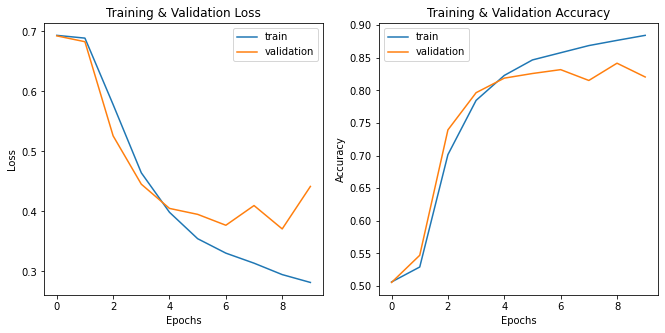

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        83.287129
Recall:    93.425144
Precision: 75.133976
Accuracy:  81.248611
--------(140, 0.4, None)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.673 | Val Acc: 50.592
Epoch 2 | Train Loss: 0.686 | Val Loss: 0.607 | Train Acc: 53.001 | Val Acc: 68.345
Epoch 3 | Train Loss: 0.532 | Val Loss: 0.509 | Train Acc: 73.967 | Val Acc: 75.671
Epoch 4 | Train Loss: 0.433 | Val Loss: 0.418 | Train Acc: 80.227 | Val Acc: 80.569
Epoch 5 | Train Loss: 0.374 | Val Loss: 0.397 | Train Acc: 83.472 | Val Acc: 82.05
Epoch 6 | Train Loss: 0.339 | Val Loss: 0.407 | Train Acc: 85.199 | Val Acc: 82.78
Epoch 7 | Train Loss: 0.314 | Val Loss: 0.371 | Train Acc: 86.708 | Val Acc: 83.235
Epoch 8 | Train Loss: 0.298 | Val Loss: 0.369 | Train Acc: 87.524 | Val Acc: 82.859
Epoch 9 | Train Loss: 0.282 | Val Loss: 0.368 | Train Acc: 88.345 | Val Acc: 84.123
Epoch 10 | Train Loss: 0.271 | Val Loss: 0.387 | Train Acc: 8

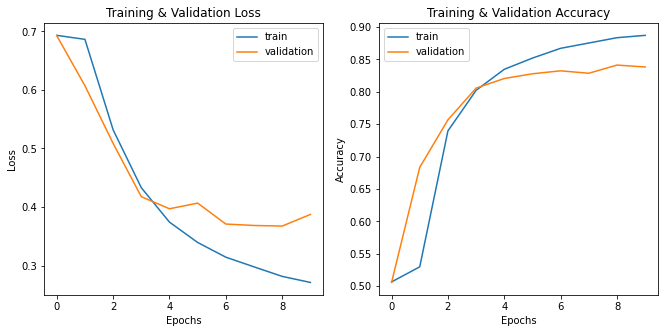

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.007278
Recall:    90.804087
Precision: 79.906177
Accuracy:  83.981337
--------(140, 0.5, 1)---------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.693 | Train Acc: 50.114 | Val Acc: 50.454
Epoch 2 | Train Loss: 0.69 | Val Loss: 0.687 | Train Acc: 52.177 | Val Acc: 53.239
Epoch 3 | Train Loss: 0.595 | Val Loss: 0.522 | Train Acc: 67.627 | Val Acc: 74.862
Epoch 4 | Train Loss: 0.472 | Val Loss: 0.441 | Train Acc: 78.058 | Val Acc: 79.878
Epoch 5 | Train Loss: 0.399 | Val Loss: 0.397 | Train Acc: 82.276 | Val Acc: 81.398
Epoch 6 | Train Loss: 0.355 | Val Loss: 0.454 | Train Acc: 84.541 | Val Acc: 79.226
Epoch 7 | Train Loss: 0.33 | Val Loss: 0.377 | Train Acc: 85.986 | Val Acc: 82.978
Epoch 8 | Train Loss: 0.316 | Val Loss: 0.366 | Train Acc: 86.545 | Val Acc: 83.985
Epoch 9 | Train Loss: 0.297 | Val Loss: 0.362 | Train Acc: 87.515 | Val Acc: 84.913
Epoch 10 | Train Loss: 0.278 | Val Loss: 0.375 | Train Acc: 88.3

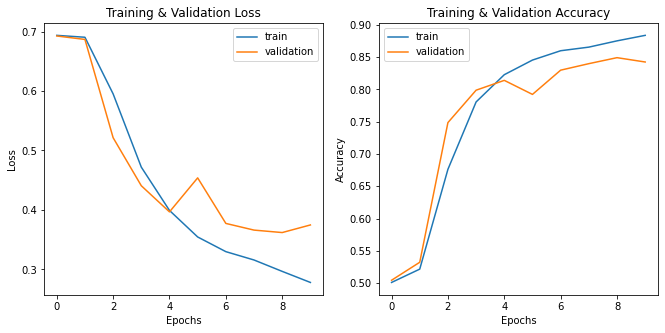

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        85.149385
Recall:    86.095069
Precision: 84.224250
Accuracy:  84.981115
--------(140, 0.5, 5)---------
Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.334 | Val Acc: 50.079
Epoch 2 | Train Loss: 0.691 | Val Loss: 0.687 | Train Acc: 52.219 | Val Acc: 53.791
Epoch 3 | Train Loss: 0.624 | Val Loss: 0.534 | Train Acc: 64.199 | Val Acc: 73.558
Epoch 4 | Train Loss: 0.486 | Val Loss: 0.469 | Train Acc: 77.146 | Val Acc: 78.653
Epoch 5 | Train Loss: 0.405 | Val Loss: 0.439 | Train Acc: 81.855 | Val Acc: 80.766
Epoch 6 | Train Loss: 0.356 | Val Loss: 0.394 | Train Acc: 84.601 | Val Acc: 82.859
Epoch 7 | Train Loss: 0.33 | Val Loss: 0.375 | Train Acc: 85.992 | Val Acc: 83.827
Epoch 8 | Train Loss: 0.315 | Val Loss: 0.364 | Train Acc: 86.598 | Val Acc: 84.301
Epoch 9 | Train Loss: 0.294 | Val Loss: 0.368 | Train Acc: 87.913 | Val Acc: 84.459
Epoch 10 | Train Loss: 0.282 | Val Loss: 0.36 | Train Acc: 88.2

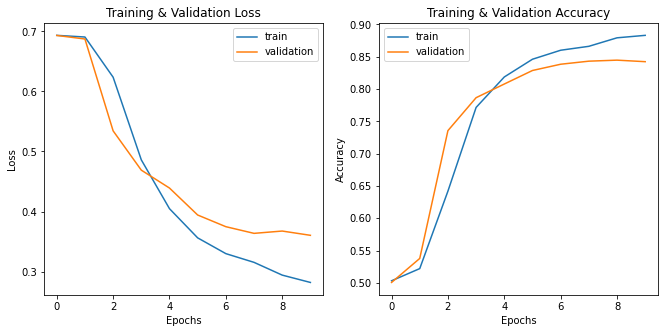

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.589274
Recall:    83.029765
Precision: 86.208487
Accuracy:  84.870029
--------(140, 0.5, None)---------
Epoch 1 | Train Loss: 0.694 | Val Loss: 0.692 | Train Acc: 49.764 | Val Acc: 52.054
Epoch 2 | Train Loss: 0.691 | Val Loss: 0.689 | Train Acc: 51.745 | Val Acc: 52.172
Epoch 3 | Train Loss: 0.658 | Val Loss: 0.548 | Train Acc: 58.593 | Val Acc: 72.986
Epoch 4 | Train Loss: 0.504 | Val Loss: 0.464 | Train Acc: 75.897 | Val Acc: 78.318
Epoch 5 | Train Loss: 0.419 | Val Loss: 0.421 | Train Acc: 80.879 | Val Acc: 79.937
Epoch 6 | Train Loss: 0.367 | Val Loss: 0.404 | Train Acc: 84.0 | Val Acc: 81.635
Epoch 7 | Train Loss: 0.341 | Val Loss: 0.521 | Train Acc: 85.374 | Val Acc: 77.073
Epoch 8 | Train Loss: 0.314 | Val Loss: 0.375 | Train Acc: 86.663 | Val Acc: 83.669
Epoch 9 | Train Loss: 0.3 | Val Loss: 0.367 | Train Acc: 87.397 | Val Acc: 84.222
Epoch 10 | Train Loss: 0.282 | Val Loss: 0.38 | Train Acc: 88.3

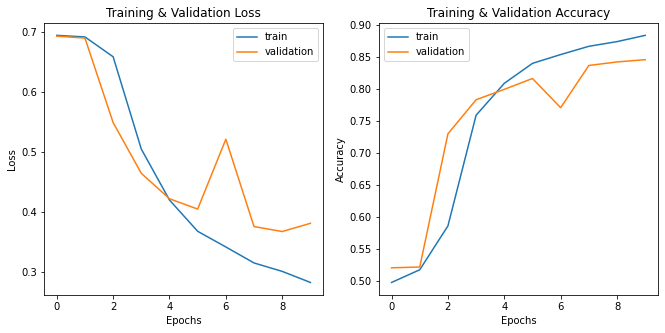

-------------------------
torch.Size([4501, 1])
torch.Size([4501])
F1:        84.860470
Recall:    85.784096
Precision: 83.956522
Accuracy:  84.692291


In [ ]:
for hs in [100,120,140]:
  for d in [0.3,0.4,0.5]:
    for c in [1,5,None]:
      print(f"--------{hs,d,c}---------")
      model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                      p=d, cell_type=nn.GRU).to(device)

      run_epochs(model, 10 , learning_rate=1e-4, clip=1,
              train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
              show_plot_cm=False, show_plot_roc_curve=False, show_epoch_results=True)

From the above results, we can see that the best model are those 120 hidden size, 0.5 dropout probability and either 1 or 5 for gradient clipping. However, they seem to slighlty overfit, so we're doing to experiment with the epochs and learning rate. Also, 0.3 dropout probability without gradient clipping performs well so it will be fine tuned.

Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.997 | Val Acc: 52.449
Epoch 2 | Train Loss: 0.682 | Val Loss: 0.588 | Train Acc: 54.293 | Val Acc: 69.629
Epoch 3 | Train Loss: 0.529 | Val Loss: 0.48 | Train Acc: 74.376 | Val Acc: 76.935
Epoch 4 | Train Loss: 0.432 | Val Loss: 0.437 | Train Acc: 80.247 | Val Acc: 79.858
Epoch 5 | Train Loss: 0.369 | Val Loss: 0.42 | Train Acc: 83.785 | Val Acc: 81.931
Epoch 6 | Train Loss: 0.34 | Val Loss: 0.384 | Train Acc: 85.337 | Val Acc: 83.314
Epoch 7 | Train Loss: 0.316 | Val Loss: 0.365 | Train Acc: 86.694 | Val Acc: 84.024
Epoch 8 | Train Loss: 0.297 | Val Loss: 0.372 | Train Acc: 87.58 | Val Acc: 84.321
Epoch 9 | Train Loss: 0.282 | Val Loss: 0.367 | Train Acc: 88.342 | Val Acc: 84.656
Epoch 10 | Train Loss: 0.267 | Val Loss: 0.364 | Train Acc: 89.211 | Val Acc: 84.577
-------------------------


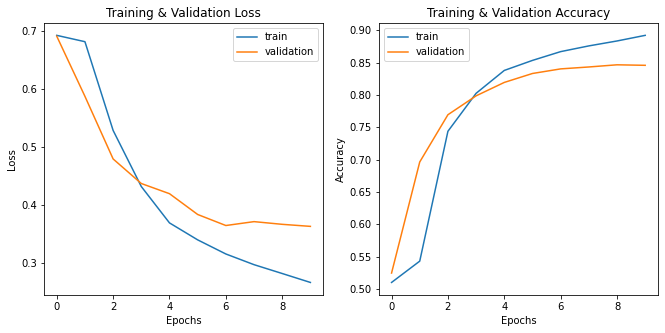

-------------------------
F1:        85.422222
Recall:    85.384274
Precision: 85.460205
Accuracy:  85.425461


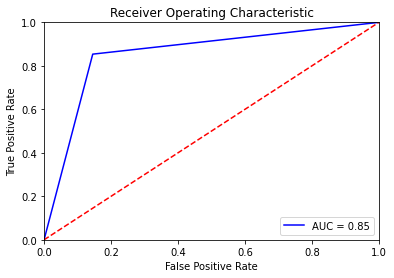

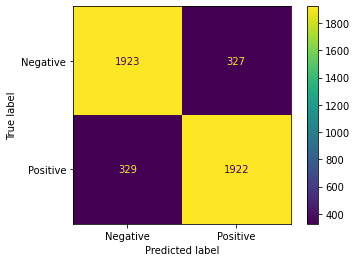

In [ ]:
model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                p=0.3, cell_type=nn.GRU).to(device)

run_epochs(model, 10 , learning_rate=1e-4, clip=None,
        train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
        show_plot_cm=True, show_plot_roc_curve=True, show_epoch_results=True, save_model="final_model2.pt")

Epoch 1 | Train Loss: 0.693 | Val Loss: 0.692 | Train Acc: 50.549 | Val Acc: 51.007
Epoch 2 | Train Loss: 0.688 | Val Loss: 0.689 | Train Acc: 52.433 | Val Acc: 53.278
Epoch 3 | Train Loss: 0.669 | Val Loss: 0.576 | Train Acc: 57.402 | Val Acc: 71.09
Epoch 4 | Train Loss: 0.559 | Val Loss: 0.534 | Train Acc: 72.285 | Val Acc: 73.894
Epoch 5 | Train Loss: 0.51 | Val Loss: 0.506 | Train Acc: 75.406 | Val Acc: 75.178
Epoch 6 | Train Loss: 0.466 | Val Loss: 0.464 | Train Acc: 78.072 | Val Acc: 78.002
Epoch 7 | Train Loss: 0.414 | Val Loss: 0.415 | Train Acc: 81.048 | Val Acc: 81.734
Epoch 8 | Train Loss: 0.371 | Val Loss: 0.38 | Train Acc: 83.619 | Val Acc: 83.136
Epoch 9 | Train Loss: 0.344 | Val Loss: 0.37 | Train Acc: 85.01 | Val Acc: 84.024
Epoch 10 | Train Loss: 0.323 | Val Loss: 0.358 | Train Acc: 86.169 | Val Acc: 84.38
-------------------------


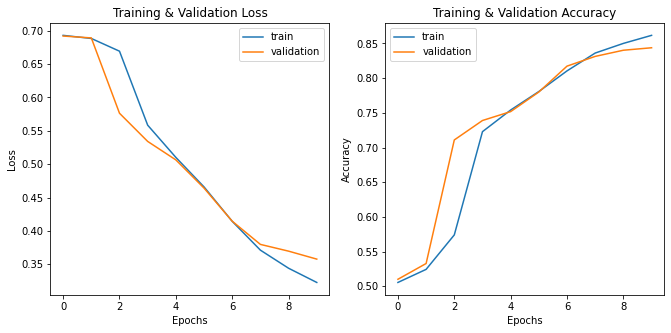

-------------------------
F1:        84.941745
Recall:    85.828521
Precision: 84.073107
Accuracy:  84.781160


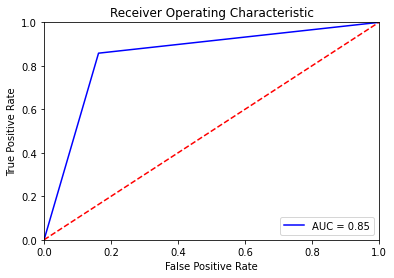

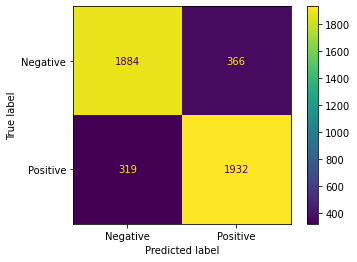

In [ ]:
model = SentimentClassifier(300, 120, pretrained_embeddings, num_of_layers=3, 
                                p=0.45, cell_type=nn.GRU).to(device)

run_epochs(model, 10 , learning_rate=1e-4, clip=5,
        train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
        show_plot_cm=True, show_plot_roc_curve=True, show_epoch_results=True, save_model="final_model.pt")

Out of the two final models, the first overfits a bit, so even though it scores better the first is selected. When comparing the results with the previous two assignemnts, there is an improvement compared to the second assignment, but I was expecting bigger gap (F1: 83.33). Compared to the first assignment, the score is lower (F1: 88.33). Again I would expect an RNN to perform better than a simple logistic regression model, but it seems like it adds complexity that is not required.

## Test the model

To run the model on other data, the following steps should be done:


1.   Load libraries/functions required
  

*   Run the section [Libraries & Connnection](#libraries)
* Run the sectionn [functions for data preparation](#dataprep)
* Run the section [functions for training](#trainprep)



2.   Load data & Model
3.   Run predictions



In [ ]:
# Try it with hidden test data
path_to_data = 'path/to/test/data'
path_to_model = 'path/final_model.pt'

# Data Preparation

df = prep_data(path_to_data)
df['tokenized_review'] = df['review'].progress_apply(glove_lstm_300_2)
df['tokenized_review_padded']=df['tokenized_review'].apply(lambda x: x[:115] if len(x)>115 else x+[1]*(115-len(x)))

X_hidden_test = df['tokenized_review_padded']
y_hidden_test = df['rating']

X_hidden_test_final = torch.tensor(X_hidden_test.to_list())
y_hidden_test_final = torch.squeeze(torch.from_numpy(y_hidden_test.to_numpy()).float())
hidden_test_set = TensorDataset(X_hidden_test_final, y_hidden_test_final)
hidden_test_loader = DataLoader(hidden_test_set, 
                                batch_size= len(hidden_test_set), 
                                shuffle= False)

# Load Model
final_model = torch.load(path_to_model) 
final_model.eval()

# Predictions & Results
test(final_model,hidden_test_loader,show_plot_roc_curve=True,show_plot_cm=True)

## References

*   Pytorch Documentation
*   https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
*   https://www.kaggle.com/getting-started/251213
*   https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

